In [1]:
# modules in this directory
import numpy as np
np.bool=bool
np.float=float
np.object=object

#Runs the predefiend veto functions & other usful fucntions
%run 00_analysis_config.ipynb


import matplotlib
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
from tqdm import tqdm
import track_analysis as TK
import event_veto as Veto
import lsfit
import scipy as sp
reload(lsfit)

#import include_modules_root as rt
#import gen_auxiliary as GAX
import Kalman_tom


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:

Data_Dir="/home/aabdulra/projects/rrg-mdiamond/aabdulra"
files_50GeV=[f"{Data_Dir}/50GeV_full_cov.root",f"{Data_Dir}/100GeV_full_cov.root",f"{Data_Dir}/300GeV_full_cov.root",f"{Data_Dir}/veto.root"]
noFW_50=files_50GeV[0]
noFW_100=files_50GeV[1]
noFW_300=files_50GeV[2]
noFW=files_50GeV[3]


# Veto stratgies Set Up

In [5]:
#

def track_analysis(filename, EventNumber=None):
    result={}
    result["track_param"]=[]
    result["track_cov"]=[]
    result["track"]=[]
    result["fw_hit"]=[]
    result["mod"]=[]
    result["event_id"]=[]
    result["deflection"]=[]


    ev = event.Event(filename, 0, tree_name="integral_tree")
    nevents_total = int(ev.Tree.GetEntries())
    tfile = root.TFile.Open(filename)
    tree_name = tfile.GetListOfKeys()[0].GetName()
    Tree = tfile.Get(tree_name)
    cut=cutflow.sample_space("")
    if EventNumber == None:
        nevents=nevents_total
    else:
        nevents=EventNumber
    
    for entry in tqdm(range(nevents)):
        Tree.GetEntry(entry)
        
        
        track_param=[]
        track_cov=[]
        track=[]
        fw_hit_group=[]
        fw_hit_group_mod=[]
        fw_hit=[]
        hit_mod=[]
        deflection=[]
        
        
        
    # Tracks
        track_digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
        track_digi_hit_pdg  =  util.unzip(Tree.Track_k_m_pdgs)
        n_tracks_recon = len(track_digi_hit_inds)
        momentum_truth = [Tree.GenParticle_py[0], -Tree.GenParticle_pz[0], Tree.GenParticle_px[0]]
        momentum_truth_unit = momentum_truth/np.linalg.norm(momentum_truth)
        if n_tracks_recon > 0:

            # Hits
            hits_x = np.array(util.c2list(Tree.Digi_x))
            hits_y = np.array(util.c2list(Tree.Digi_y))
            hits_z = np.array(util.c2list(Tree.Digi_z))
            hits_t = np.array(util.c2list(Tree.Digi_time))
            hits_pdg = np.array(util.c2list(Tree.Digi_pdg_id))
            hits_layer = np.array(util.c2list(Tree.Digi_layer_id))
            mask_non_fw = (hits_z>=MODULE_Z_RANGE_CMS_cm[0]) & (hits_y>=MODULE_Y_RANGE_CMS_cm[0])
            hits_xyz_non_fw = np.array([hits_x[mask_non_fw], hits_y[mask_non_fw], hits_z[mask_non_fw], hits_t[mask_non_fw]]).T
            hits_xyz_fw = np.array([hits_x[~mask_non_fw], hits_y[~mask_non_fw], hits_z[~mask_non_fw], hits_t[~mask_non_fw]]).T
            hits_id_fw = hits_layer[~mask_non_fw]
            n_hits_fw = len(hits_xyz_fw)
            
            # Loop track, and for each track loop F/W hits
            if n_hits_fw > 0 :
                    for itrack in range(n_tracks_recon):
                        if track_digi_hit_pdg[itrack][0]==13: 
                            # get the track parameter from the tree#
                            track_param.append(get_track_param(Tree, itrack))
                            # get the covariant matrix of the reconstructed tracks from the tree#
                            track_cov.append(get_track_cov(Tree, itrack))
                            # get the track estimation form the tree#
                            track.append(get_track (Tree, itrack))
                            
                            # calculate the momentum for the deflection angle calculation #
                            momentum_measured = get_track_param(Tree, itrack)[3:6]
                            momentum_measured_unit = momentum_measured/np.linalg.norm(momentum_measured)
                            try:
                                deflection.append(np.arccos(np.dot(momentum_truth_unit, momentum_measured_unit)))
                            except:
                                print(momentum_measured)
                    # remove F/W digitized hits that fall within a gap and save the modular f/w hits seperatly from the hermatic f/w hits #
                    for ihit, hit in enumerate(hits_xyz_fw):
                        if  hits_pdg[ihit] == 13:
                            fw_hit.append(hit)
                            if inGap(hit) == False:
                                hit_mod.append(hit)
                    # Hermetic f/w hit per event #             
                    fw_hit_group.append(fw_hit)
                    # Modular f/w hit per event #
                    fw_hit_group_mod.append(hit_mod)
        # save to a dict #
        result["track"].append(track)
        result["fw_hit"].append(fw_hit_group)
        result["track_cov"].append(track_cov)     
        result["track_param"].append(track_param)
        result["mod"].append(fw_hit_group_mod)
        result["deflection"].append(deflection)
        result["event_id"].append(entry)
            
    return result
                    

In [6]:
data=track_analysis(noFW_100)

100%|██████████| 17390/17390 [00:13<00:00, 1302.98it/s]


In [235]:

# extends the reconstructed track, finds the intercept with either F/W and calculates distance to gap seperetly#
# this is specifically applied to events that have no f/w digitized hits, since this constitutes the entirety of the efficincy loss coming from Modular#  
def  D2gap_analysis(data):

    track_d2g_all=[]
    deflection_all_mod=[]
    fw_hit_all_mod=[]
    track_all_mod=[]
    track_par_all_mod=[]

    mod={}
    mod["deflection"]=[]
    mod["d2gap"]=[]
    mod["track"]=[]
    mod["fw_hit"]=[]
    mod["track_par"]=[]
    mod["nevents"]=[]
    nevents=0
    
    for ind in  tqdm(range(len(data["track_param"]))):


        track_d2g=[]
        track_ip_par=[]
        track_deflection=[]
        

        if len(data["track_param"][ind]) >0 and len(data["mod"][ind][0]) == 0:   
            for t_id in range(len(data["track_param"][ind])):           

                track_par  = data["track_param"][ind][t_id]
                track_cov  = data["track_cov"][ind][t_id]
                track      = data["track"][ind][t_id]
             
                track_d2g.append(find_d2g_intercept(track_par,track))
                track_deflection.append(get_deflection(track_par,track))
                
            nevents = nevents + 1 
            if np.min(track_d2g) > -999:
                ind_d2g_min=np.argmin(track_d2g)
                track_d2g_all.append(track_d2g[ind_d2g_min])
                deflection_all_mod.append(track_deflection[ind_d2g_min])
                track_all_mod.append(data["track"][ind])
                fw_hit_all_mod.append(data["mod"][ind][0])
                track_par_all_mod.append( data["track_param"][ind] )
                mod["deflection"]=np.array(deflection_all_mod) 
                mod["d2gap"]=np.array(track_d2g_all)
                mod["track_par"]=np.array(track_par_all_mod)
                mod["fw_hit"]=np.array(fw_hit_all_mod,dtype=object)
                mod["track"]=np.array(track_all_mod,dtype=object)
                


    mod["nevents"].append(nevents)
    return mod


In [236]:
dist2gap=D2gap_analysis(data)

  0%|          | 0/13757 [00:00<?, ?it/s]/tmp/ipykernel_24261/3337555539.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mod["track_par"]=np.array(track_par_all_mod)
100%|██████████| 13757/13757 [00:00<00:00, 18811.64it/s]


In [3]:
# calculates the Veto chi2 for the ip tracklet and the projection stratgies for both modular and Hermetic#

def get_veto(data):
    track_ip_chi2_all=[]
    track_fwhits_chi2_all=[]
    track_ip_chi2_all_mod=[]
    track_fwhits_chi2_all_mod=[]
    track_ip_chi2_dist_all=[]
    track_fwhits_chi2_dist_all=[]
    track_ip_chi2_dist_all_mod=[]
    track_fwhits_chi2_dist_all_mod=[]
    track_d2g_all=[]
    deflection_all=[]
    deflection_all_mod=[]
    fail_mask=[]
    fw_hit_all=[]
    track_all=[]
    fw_hit_all_mod=[]
    track_all_mod=[]
    results={}
    results["Ip_chi2"]=[]
    results["track"]=[]
    results["fw_hit"]=[]
    results["fwhit_chi2"]=[]
    results["Ip_chi2_dist"]=[]
    results["fwhit_chi2_dist"]=[]
    results["deflection"]=[]
    
    mod={}
    mod["Ip_chi2"]=[]
    mod["fwhit_chi2"]=[]
    mod["Ip_chi2_dist"]=[]
    mod["fwhit_chi2_dist"]=[]
    mod["deflection"]=[]
    mod["d2gap"]=[]
    mod["track"]=[]
    mod["fw_hit"]=[]
    mod["track_par"]=[]
    mod["fail_mask"]=[]
    
    
    for ind in  tqdm(range(len(data["track_param"]))):
        track_ip_chi2=[]
        track_fwhits_chi2=[]
        track_ip_chi2_dist=[]
        track_fwhits_chi2_dist=[] 
        track_ip_chi2_mod=[]
        track_fwhits_chi2_mod=[]
        track_ip_chi2_dist_mod=[]
        track_fwhits_chi2_dist_mod=[]
        track_d2g=[]
        track_ip_par=[]
        track_deflection=[]
        
        # making sure that the event has tracks #
        if len(data["track_param"][ind]) >0:
            for t_id in range(len(data["track_param"][ind])):
                
                tracks_ip_chi2=[]
                tracks_fwhits_chi2=[]
                tracks_ip_chi2_mod=[]
                tracks_fwhits_chi2_mod=[]
                tracks_ip_chi2_dist_mod=[]
                tracks_fwhits_chi2_dist_mod=[]
                tracks_ip_chi2_dist=[]
                tracks_fwhits_chi2_dist=[]
                tracks_d2g=[]
                
                
                track_par  = data["track_param"][ind][t_id]
                track_cov  = data["track_cov"][ind][t_id]
                track      = data["track"][ind][t_id]

                # going over all hermetic f/w hits in the event#
                for hit in data["fw_hit"][ind][0]:
                    track_info = [track_cov,track_par]
                    try:
                        tracks_ip_chi2.append(Track_to_IPtrack_chi2(hit, track_info)[0])
                        tracks_fwhits_chi2.append(fwhits_to_chi2(hit,track_info)[0])
                    except: 
                        continue
                    tracks_ip_chi2_dist.append(Track_to_IPtrack_chi2(hit, track_info)[1:])
                    tracks_fwhits_chi2_dist.append(fwhits_to_chi2(hit,track_info)[1])
                if len(tracks_ip_chi2) > 0:   
                    ind_min = np.argmin(tracks_fwhits_chi2)    
                    track_ip_chi2.append(tracks_ip_chi2[ind_min])
                track_fwhits_chi2.append(tracks_fwhits_chi2[ind_min])
                track_ip_chi2_dist.append(tracks_ip_chi2_dist[ind_min])
                track_fwhits_chi2_dist.append(tracks_fwhits_chi2_dist[ind_min])
                
                
                # going over all Modular f/w hits in the event#
                for hit in data["mod"][ind][0]:
                    track_info = [track_cov,track_par]
                    tracks_ip_chi2_mod.append(Track_to_IPtrack_chi2(hit, track_info)[0])
                    tracks_fwhits_chi2_mod.append(fwhits_to_chi2(hit,track_info)[0])
                    tracks_ip_chi2_dist_mod.append(Track_to_IPtrack_chi2(hit, track_info)[1:])
                    tracks_fwhits_chi2_dist_mod.append(fwhits_to_chi2(hit,track_info)[1])
                    
                # for events that have F/W digitized hits calculate the normal veto (tracklet + projection ) #    
                if len(tracks_fwhits_chi2_mod) > 0:                               
                    ind_min_mod = np.argmin(tracks_fwhits_chi2_mod)    
                    track_ip_chi2_mod.append(tracks_ip_chi2_mod[ind_min_mod])
                    track_fwhits_chi2_mod.append(tracks_fwhits_chi2_mod[ind_min_mod])
                    track_ip_chi2_dist_mod.append(tracks_ip_chi2_dist_mod[ind_min_mod])
                    track_fwhits_chi2_dist_mod.append(tracks_fwhits_chi2_dist_mod[ind_min_mod])
                # for events' without F/W digitized hits  calculate distance to gap #
                else:
                    # the function "find_d2g_intercept" returns -999 if the track is projected out of box
                    if find_d2g_intercept(track_par,track) > -999:
                        track_d2g.append(find_d2g_intercept(track_par,track))
                    track_deflection.append(get_deflection(track_par,track))
            if len(track_ip_chi2) > 0:    
                track_min_ind=np.argmin(track_ip_chi2)
                    
                deflection_all.append(data["deflection"][ind][track_min_ind])
                           
        # distance #                                    
                            
            track_ip_chi2_dist_all.append(track_ip_chi2_dist[track_min_ind])
            track_fwhits_chi2_dist_all.append(track_ip_chi2_dist[track_min_ind])
            track_all.append(data["track"][ind][track_min_ind])
            fw_hit_all.append(data["fw_hit"][ind][0])
                                            
        # Chi2 #                                    
            track_ip_chi2_all.append(np.min(track_ip_chi2))
            track_fwhits_chi2_all.append(np.min(track_fwhits_chi2))
     
        #Modular#
            if len(track_fwhits_chi2_mod) >0:  
                fail_mask.append(False)
                track_min_ind_mod=np.argmin(track_ip_chi2_mod)   
                track_d2g_all.append(-999)
                deflection_all_mod.append(-999)
                track_ip_chi2_all_mod.append(np.min(track_ip_chi2_mod)) 
                track_fwhits_chi2_all_mod.append(np.min(track_fwhits_chi2_mod)) 
                track_ip_chi2_dist_all_mod.append(track_ip_chi2_dist_mod[track_min_ind_mod])
                track_fwhits_chi2_dist_all_mod.append(track_ip_chi2_dist_mod[track_min_ind_mod])  
                track_all_mod.append(data["track"][ind][track_min_ind_mod])
                fw_hit_all_mod.append(data["mod"][ind][0])
                track_ip_par.append(data["track_param"][ind])
            else:
                if len(track_d2g) > 0:
                    ind_d2g_min=np.argmin(track_d2g)
                    track_d2g_all.append(track_d2g[ind_d2g_min])
                    deflection_all_mod.append(track_deflection[ind_d2g_min])
                else:
                    track_d2g_all.append(-999)
                    deflection_all_mod.append(-999)
                       
                track_all_mod.append(data["track"][ind])
                fw_hit_all_mod.append(data["mod"][ind][0])
                fail_mask.append(True)

                track_ip_chi2_all_mod.append(-999) 
                track_fwhits_chi2_all_mod.append(-999) 
                track_ip_chi2_dist_all_mod.append(-999)
                track_fwhits_chi2_dist_all_mod.append(-999)  
                track_ip_par.append(data["track_param"][ind])
                
                
    results["Ip_chi2"]=np.array(track_ip_chi2_all)
    results["fwhit_chi2"]=np.array(track_fwhits_chi2_all)
    results["Ip_chi2_dist"]=np.array(track_ip_chi2_dist_all)
    results["fwhit_chi2_dist"]=np.array(track_fwhits_chi2_dist_all)
    if len(deflection_all) > 0:
        results["deflection"]=np.array(deflection_all)
    results["fw_hit"]=np.array(fw_hit_all,dtype=object)
    results["track"]=np.array(track_all,dtype=object)    
    

    mod["fail_mask"]=np.array(fail_mask)
    mod["Ip_chi2"]=np.array(track_ip_chi2_all_mod)
    mod["fwhit_chi2"]=np.array(track_fwhits_chi2_all_mod)
    mod["Ip_chi2_dist"]=np.array(track_ip_chi2_dist_all_mod)
    mod["fwhit_chi2_dist"]=np.array( track_fwhits_chi2_dist_all_mod)
    mod["deflection"]=np.array(deflection_all_mod) 
    mod["d2gap"]=np.array(track_d2g_all)
    mod["track_par"]=np.array(track_ip_par)
    mod["fw_hit"]=np.array(fw_hit_all_mod,dtype=object)
    mod["track"]=np.array(track_all_mod,dtype=object)

    
    return results, mod


In [ ]:
# save the dict to drive using joblib#
import joblib
import os

# run the veto function#

hermetic,modular = get_veto(data)

# change to your own save location#
savedir= "/home/aabdulra/projects/rrg-mdiamond/aabdulra/"
filename_h  = os.path.join(savedir, "hermetic.joblib")
filename_mod = os.path.join(savedir, "Modular.joblib")

joblib.dump(hermetic, filename_h) 
joblib.dump(modular, filename_mod) 

In [18]:

track_ip_chi2_all=[]
track_fwhits_chi2_all=[]
track_d2g_all=[]
mod_loss=[]
for eve in tqdm(data):
    track_ip_chi2=[]
    track_fwhits_chi2=[]
    track_d2g=[]
    for ind in range(len(eve["track_param"])):
        track_par= eve["track_param"][ind]
        track_cov= eve["track_cov"][ind]
        track=eve["track"][ind]
        tracks_ip_chi2=[]
        tracks_fwhits_chi2=[]  
        tracks_d2g=[]
        if len(eve["fw_hit"][0]) > 0:
            for hit in eve["fw_hit"][0]:
                track_info = [track_cov,track_par]
                tracks_ip_chi2.append(Track_to_IPtrack_chi2(hit, track_info))
                tracks_fwhits_chi2.append(fwhits_to_chi2(hit,track_info))
                tracks_d2g.append(get_d2g(hit,track))
            ind_min = np.argmin(tracks_fwhits_chi2)    
            track_ip_chi2.append(tracks_ip_chi2[ind_min])
            track_fwhits_chi2.append(tracks_fwhits_chi2[ind_min ])
            track_d2g.append(np.min(tracks_d2g))
        else:
            mod_loss.append(1)
    track_fwhits_chi2_all.append(np.min(track_fwhits_chi2) if len(track_fwhits_chi2) > 0 else -999)
    track_ip_chi2_all.append(np.min(track_ip_chi2) if len(track_fwhits_chi2) > 0 else -999)
    track_d2g_all.append(np.min(track_d2g) if len(track_d2g) > 0 else -999)

100%|██████████| 8611/8611 [23:51<00:00,  6.01it/s]


# Veto Analysis

In [3]:

# Load the dictionaries using Joblib#
savedir  ="/home/aabdulra/projects/rrg-mdiamond/aabdulra/"
veto_mod =joblib.load(f"{savedir}/modular_v3.joblib")
veto_herm=joblib.load(f"{savedir}/hermetic.joblib")
d2g_mod  =joblib.load(f"{savedir}/modular_v5_gap.joblib")

In [98]:
bins=[0,5,10,15,20,25,30]
eff_gain=[]
for binpoint in bins:
    frac=0
    for deflect in veto_herm["deflection"]/np.pi*180:
        if deflect <= binpoint:
            frac=frac+1
    eff_gain.append(1-( frac/len(veto_herm["deflection"]) ))
eff_gain

[1.0,
 0.22035591065916105,
 0.04003994915562015,
 0.008806972943526392,
 0.0019066642455056737,
 0.0004539676775013879,
 0.0]

In [ ]:
nevents=len(veto_herm["fwhit_chi2"])
chi_fw_cut =  veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 5]
chi_ip_cut =  veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 7]
chi_doca_cut = veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 10]
survive = np.round(np.array([1,len(chi_fw_cut)/nevents,len(chi_ip_cut)/nevents,len(chi_doca_cut)/nevents]),2)
proj="proj"
Tracklet="Tracklet"
plt.hist(veto_herm["deflection"]/np.pi*180, label = "Track deflection in earth");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2  >= 5]/np.pi*180, label =        "For $\chi_{R}^{2}$ >= 5"  );
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 7]/np.pi*180, label =         "For $\chi_{R}^{2}$ >= 7");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2  >= 10]/np.pi*180,label= "For $\chi_{R}^{2}$ >= 10" );






title("Track deflection in earth for Veto inefficincy ")
yscale("log")
ylim(bottom=1 )
legend()
xlabel(r"deflection angle, [$^\circ$]")
legend1=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

lines = plt.gca().get_lines()
plt.gca().add_artist(legend1)

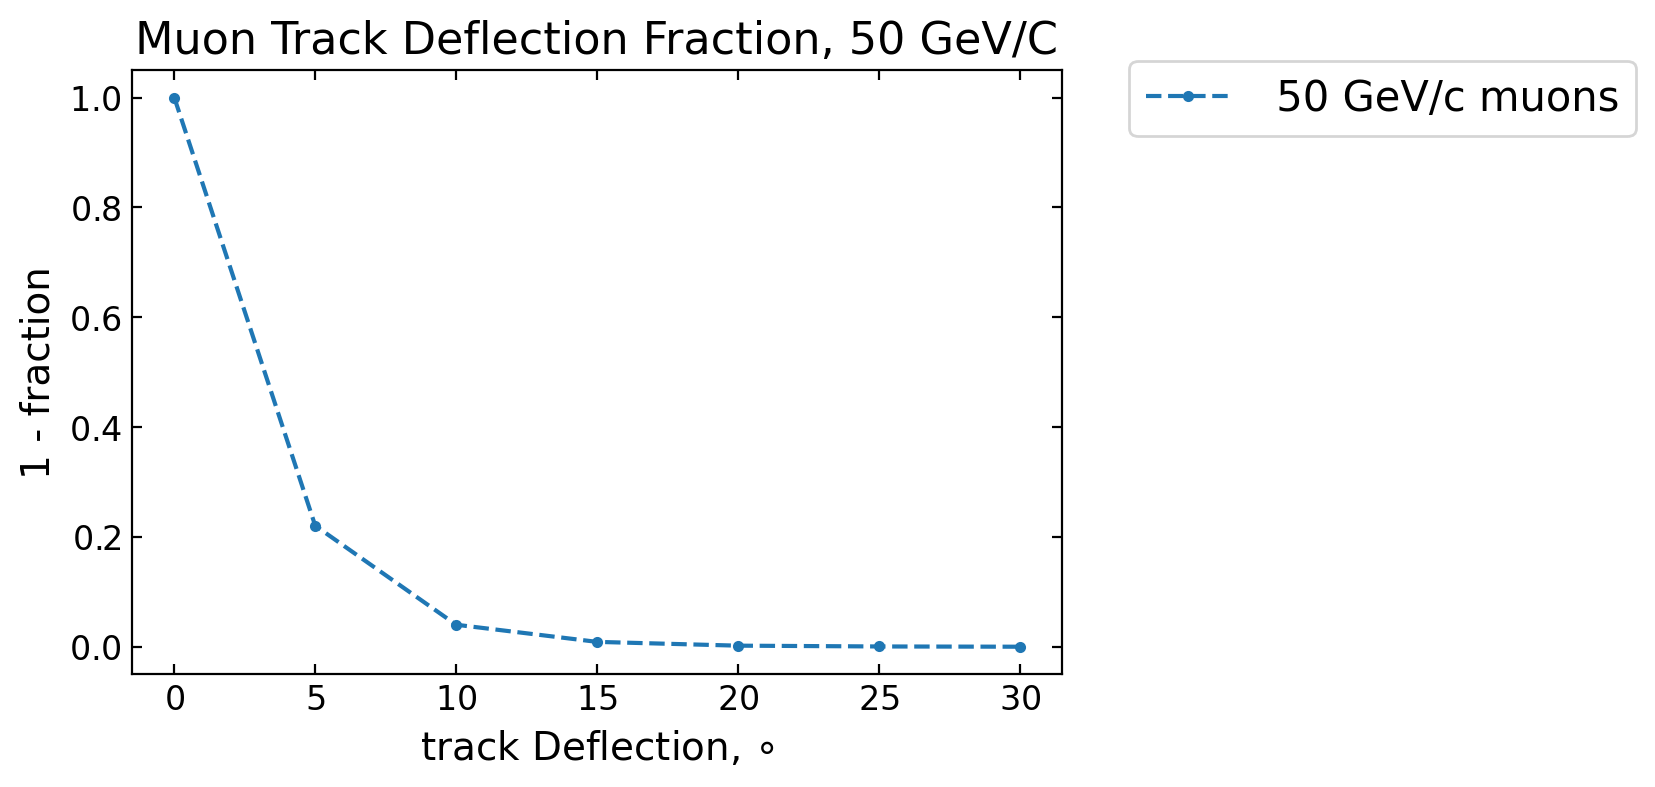

In [66]:
bins=[0,5,10,15,20,25,30]
p_mag_fraction= [1.0,
 0.22035591065916105,
 0.04003994915562015,
 0.008806972943526392,
 0.0019066642455056737,
 0.0004539676775013879,
 0.0]
plt.errorbar(bins, p_mag_fraction,ls="--" ,fmt=".", capsize=4, label = " 50 GeV/c muons" );

title(f" Muon Track Deflection Fraction, 50 GeV/C ")
legend()
ylabel("1 - fraction")
xlabel("track Deflection, $\circ$")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

## Hermatic 

In [76]:


## Hermetic Effeciancy ##
veto_list=[5,7,10]
eff=[]
eff_ip=[]
eff_fwhit=[]
eff_dist=[]
n_events=len(veto_herm["fwhit_chi2"])

# For all Tracklet chi2 cuts #
for veto in veto_list:
    vetoed_dist=0
    vetoed_ip = 0
    vetoed_fwhit=0
    for ind in range(len(veto_herm["fwhit_chi2"])):
        
        dist_list=[]
        
        # change the DOCA cut #
        if veto_herm["Ip_chi2_dist"][ind][1] <= 200:
            vetoed_dist = vetoed_dist + 1
        # the %2 is because we are considering the reduced chi2 #
        elif veto_herm["Ip_chi2"][ind]/ 2 <= veto:
            vetoed_ip  = vetoed_ip  +1
        # Change the projection chi2 cut #    
        elif veto_herm["fwhit_chi2"][ind] <= 15:
            vetoed_fwhit = vetoed_fwhit + 1

            
    vetoed=vetoed_fwhit+ vetoed_ip+ vetoed_dist
    eff.append(((vetoed/n_events)))
    eff_ip.append(vetoed_ip/n_events)
    eff_fwhit.append(vetoed_fwhit/n_events)
    eff_dist.append(vetoed_dist/n_events)

eff

[0.9827492282549483, 0.9834755765389505, 0.9846558925004539]

In [54]:
#DOCA <= 100 #
doca_100_cut_5=np.array([0.9329035772652987, 0.9433448338478301, 0.9526965680043581])
doca_100_cut_7=np.array([0.9351734156528055, 0.9445251498093336, 0.9535137098238605])
doca_100_cut_15=np.array([0.9510622843653532, 0.9536045033593609, 0.9577810059923734])

#DOCA <= 200  #
doca_200_cut_5 = np.array([0.981024151080443, 0.9829308153259488, 0.9844743054294535])
doca_200_cut_7 = np.array([0.9814781187579444, 0.9830216088614491, 0.9845650989649537])
doca_200_cut_15 = np.array([0.9827492282549483, 0.9834755765389505, 0.9846558925004539])

# DOCA <= 300 #
doca_300_cut_5=np.array([0.9928273106954785, 0.9934628654439804, 0.9940984201924823])
doca_300_cut_7=np.array([0.9928273106954785, 0.9934628654439804, 0.9940984201924823])
doca_300_cut_15=np.array([0.9933720719084801, 0.9936444525149809, 0.9940984201924823])

# DOCA <= 400 #
doca_400_cut_5  =np.array([0.9967314327219902, 0.9970946068639913, 0.9971854003994916])
doca_400_cut_7  =np.array([0.9967314327219902, 0.9970946068639913, 0.9971854003994916])
doca_400_cut_15 =np.array([0.9969130197929907, 0.9971854003994916, 0.9971854003994916])

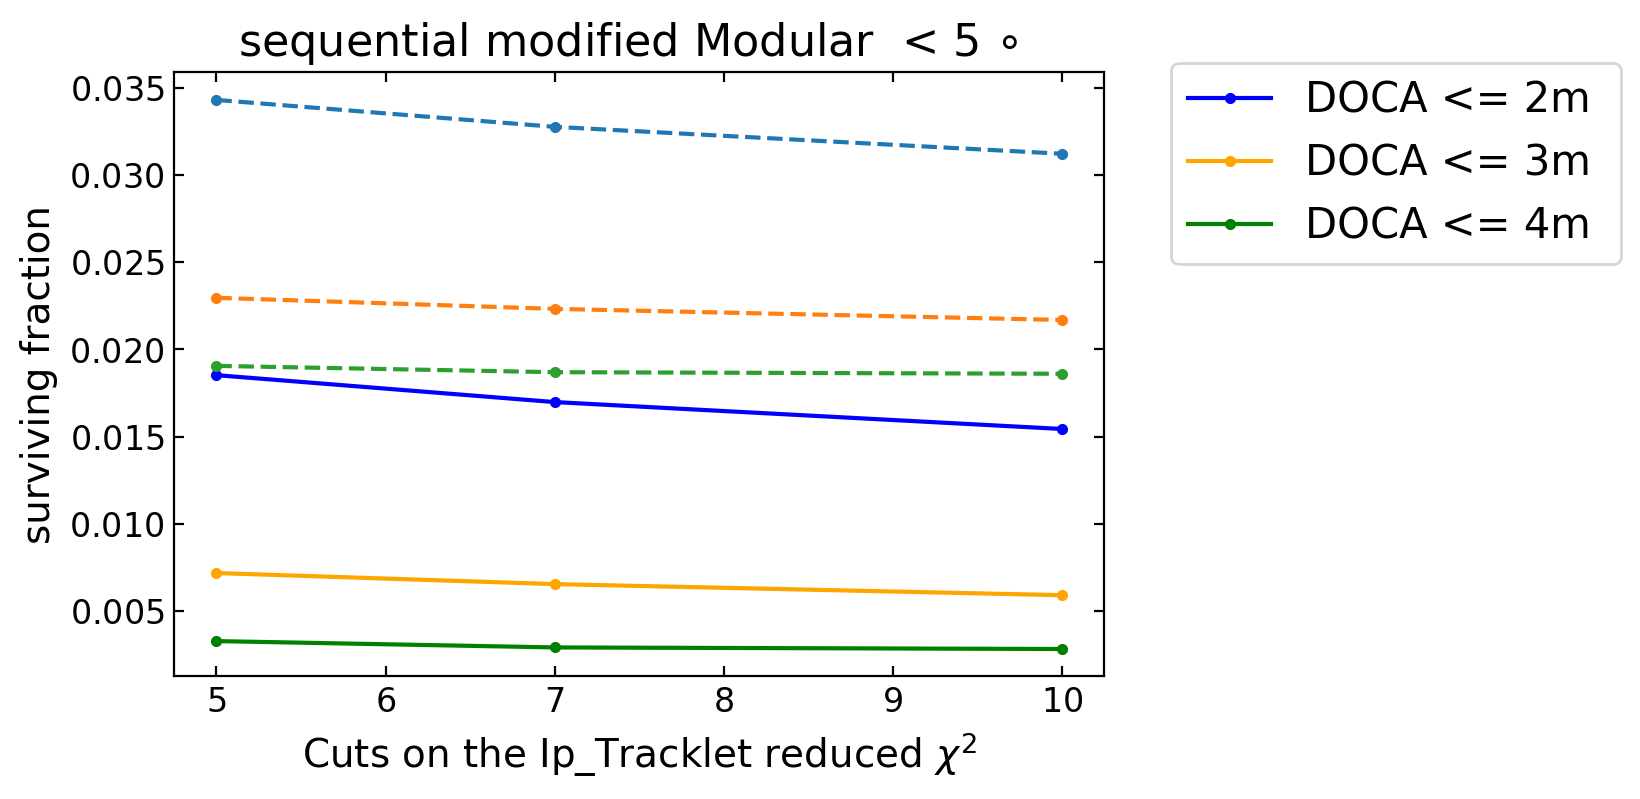

In [65]:
bincenters=[5,7,10]
DOCA=[100,200,300,400]

plt.errorbar(bincenters,(1- doca_200_cut_7  ) ,ls="-" ,fmt=".", capsize=4, color ="blue", label= "DOCA <= 2m");
plt.errorbar(bincenters,(1- doca_300_cut_7  )  ,ls="-" ,fmt=".", capsize=4,color ="orange" ,label= "DOCA <= 3m ");
plt.errorbar(bincenters,(1- doca_400_cut_7 )  ,ls="-" ,fmt=".", capsize=4,color ="green", label= "DOCA <= 4m");

plt.errorbar(bincenters,(1- doca_200_cut_7  + survive_5[-1]) ,ls="--" ,fmt=".", capsize=4);
plt.errorbar(bincenters,(1- doca_300_cut_7  + survive_5[-1])  ,ls="--" ,fmt=".", capsize=4);
plt.errorbar(bincenters,(1- doca_400_cut_7 + survive_5[-1])  ,ls="--" ,fmt=".", capsize=4);


title(f"sequential modified Modular  < 5 $\circ$  ")
#legend()
ylabel("surviving fraction")

xlabel("Cuts on the Ip_Tracklet reduced $\chi^2$")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

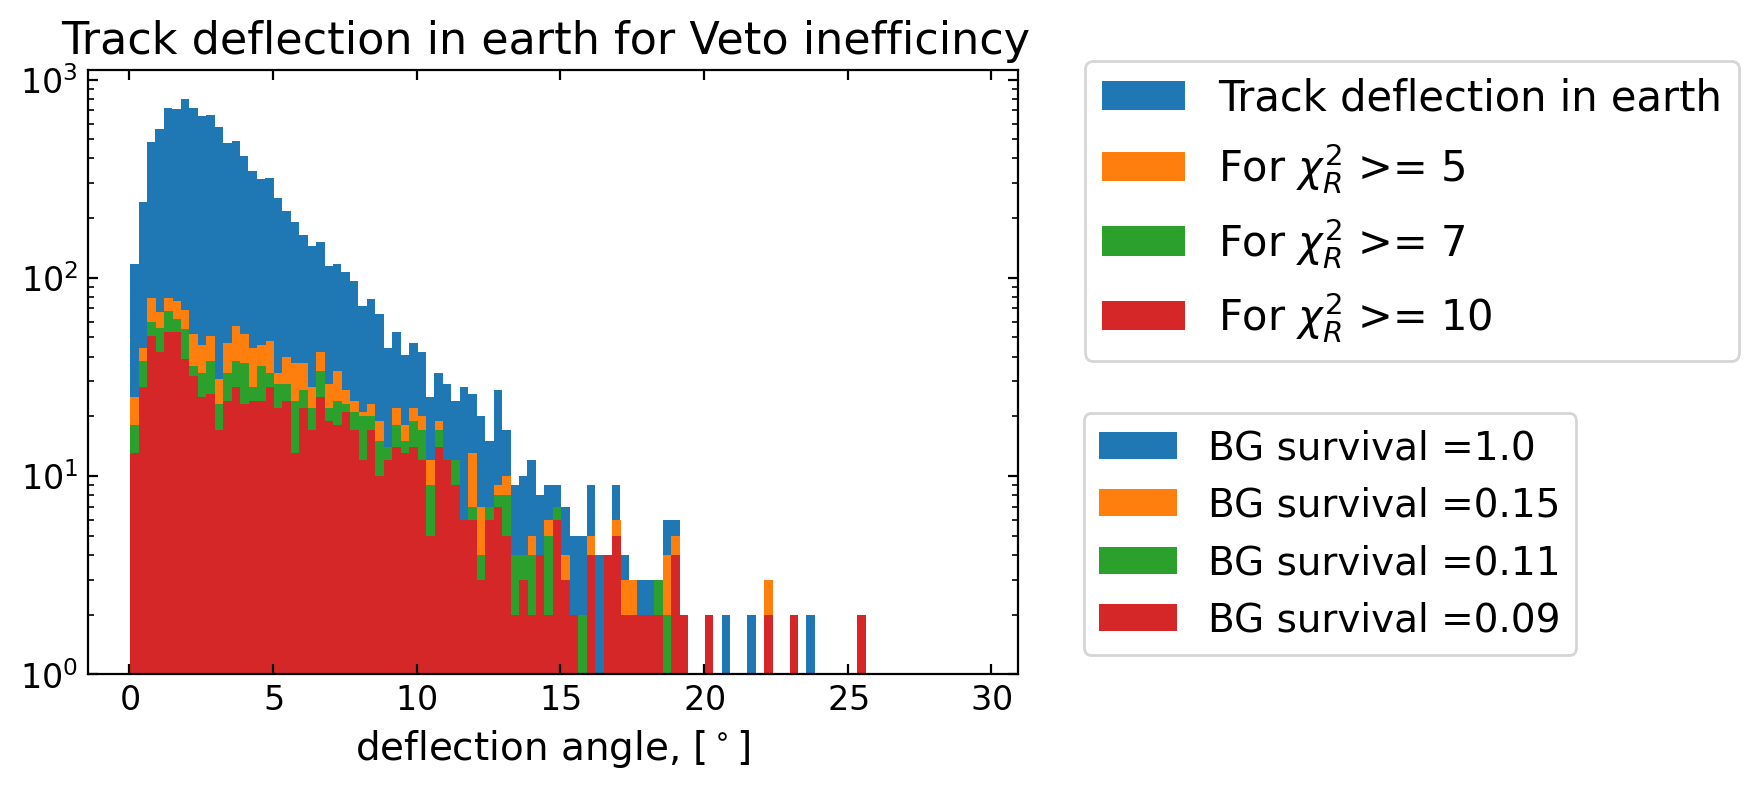

In [90]:
nevents=len(veto_herm["fwhit_chi2"])
chi_fw_cut =  veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 5]
chi_ip_cut =  veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 7]
chi_doca_cut = veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 10]
survive = np.round(np.array([1,len(chi_fw_cut)/nevents,len(chi_ip_cut)/nevents,len(chi_doca_cut)/nevents]),2)
proj="proj"
Tracklet="Tracklet"
plt.hist(veto_herm["deflection"]/np.pi*180, label = "Track deflection in earth");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2  >= 5]/np.pi*180, label =        "For $\chi_{R}^{2}$ >= 5"  );
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2 >= 7]/np.pi*180, label =         "For $\chi_{R}^{2}$ >= 7");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"]/2  >= 10]/np.pi*180,label= "For $\chi_{R}^{2}$ >= 10" );






title("Track deflection in earth for Veto inefficincy ")
yscale("log")
ylim(bottom=1 )
legend()
xlabel(r"deflection angle, [$^\circ$]")
legend1=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

lines = plt.gca().get_lines()
plt.gca().add_artist(legend1)

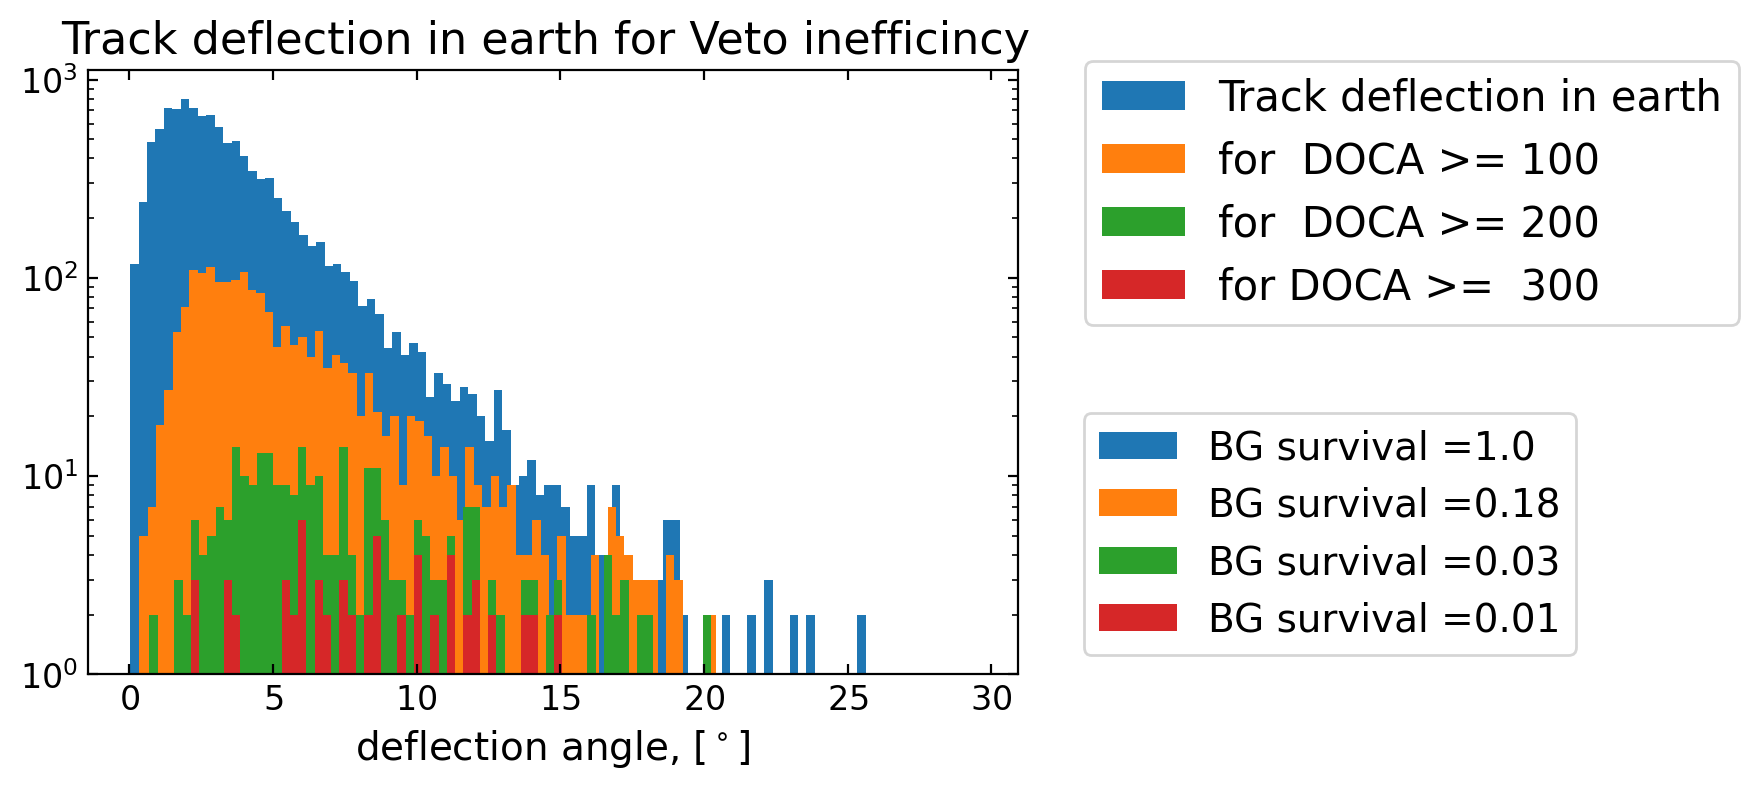

In [91]:
nevents=len(veto_herm["fwhit_chi2"])
chi_fw_cut =  veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 100]
chi_ip_cut =  veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 200]
chi_doca_cut = veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 300]
survive = np.round(np.array([1,len(chi_fw_cut)/nevents,len(chi_ip_cut)/nevents,len(chi_doca_cut)/nevents]),2)
proj="proj"
Tracklet="Tracklet"
plt.hist(veto_herm["deflection"]/np.pi*180, label = "Track deflection in earth");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 100]/np.pi*180, label =        f"for  DOCA >= 100"  );
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 200]/np.pi*180, label =         f"for  DOCA >= 200" );
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2_dist"][:,1] >= 300]/np.pi*180,label= f"for DOCA >=  300" );






title("Track deflection in earth for Veto inefficincy ")
yscale("log")
ylim(bottom=1 )
legend()
xlabel(r"deflection angle, [$^\circ$]")
legend1=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

lines = plt.gca().get_lines()
plt.gca().add_artist(legend1)

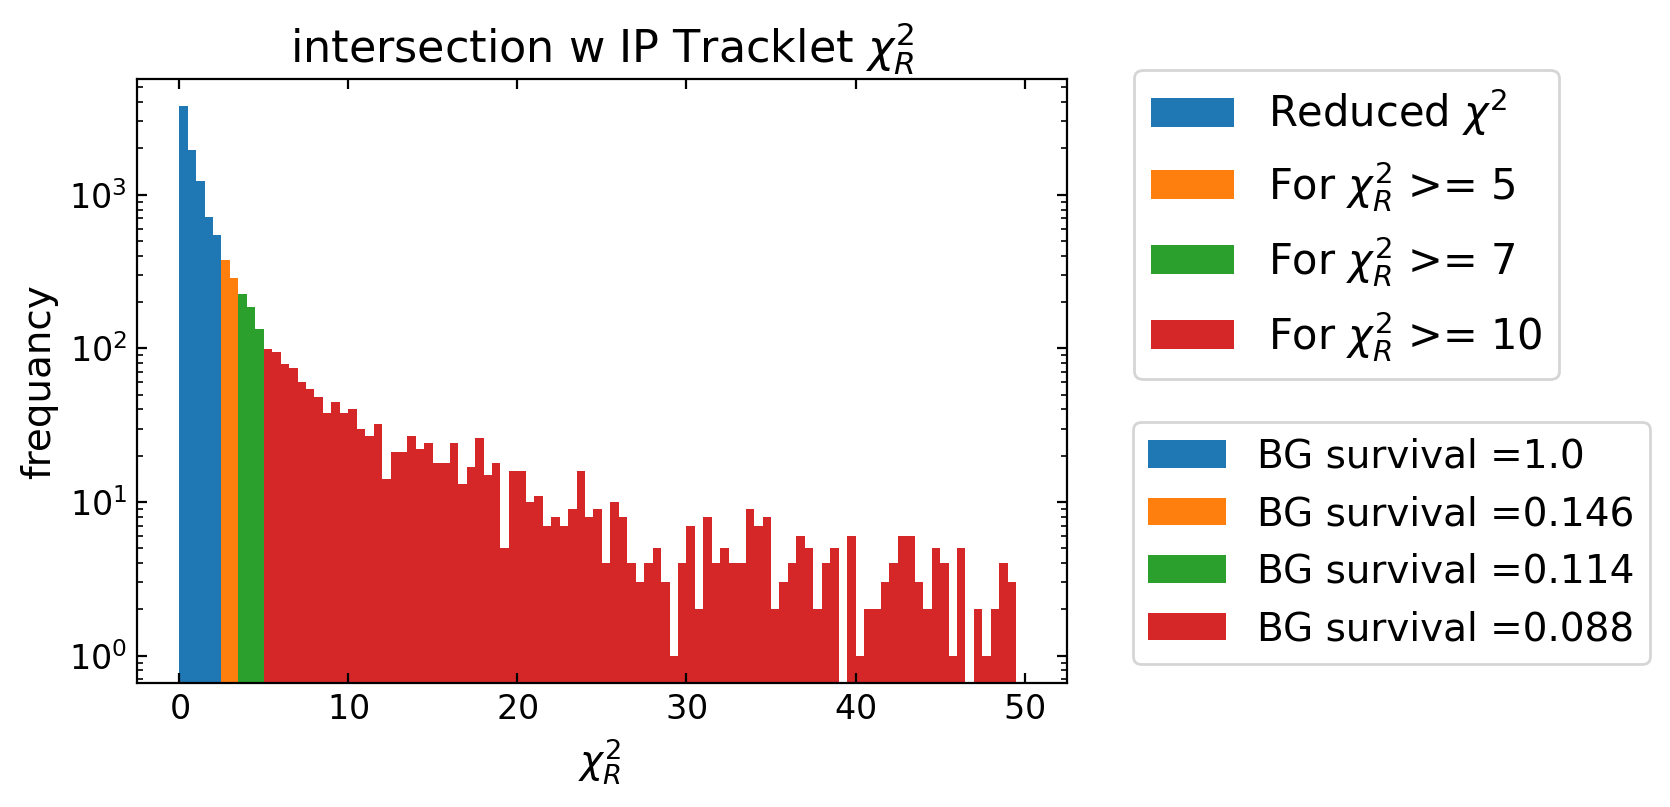

In [69]:
bincenters=[5,7,10]
chi_5_cut =  veto_herm["Ip_chi2"][veto_herm["Ip_chi2"]>= 10]
chi_7_cut =  veto_herm["Ip_chi2"][veto_herm["Ip_chi2"]>= 14]
chi_10_cut = veto_herm["Ip_chi2"][veto_herm["Ip_chi2"]>= 20]
survive=np.round(np.array([1,len(chi_5_cut)/nevents,  len(chi_7_cut)/nevents,   len(chi_10_cut)/nevents]),3)

plt.hist((veto_herm["Ip_chi2"]/2) , range= [0,50], label = "Reduced $\chi^{2}$ ");
plt.hist(veto_herm["Ip_chi2"][veto_herm["Ip_chi2"]>= 5]/2, range= [0,50] , label = "For $\chi_{R}^{2}$ >= 5");
plt.hist(veto_herm["Ip_chi2"][veto_herm["Ip_chi2"] >= 7]/2, range= [0,50] , label = "For $\chi_{R}^{2}$ >= 7");
plt.hist(veto_herm["Ip_chi2"][veto_herm["Ip_chi2"] >= 10]/2, range= [0,50] , label= "For $\chi_{R}^{2}$ >= 10");

title("intersection w IP Tracklet $\chi_{R}^{2}$")
legend()
yscale("log")
ylabel("frequancy")
xlabel("$\chi_{R}^{2}$ ")
reduced_chi2_sur=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })
lines = plt.gca().get_lines()
plt.gca().add_artist(reduced_chi2_sur)

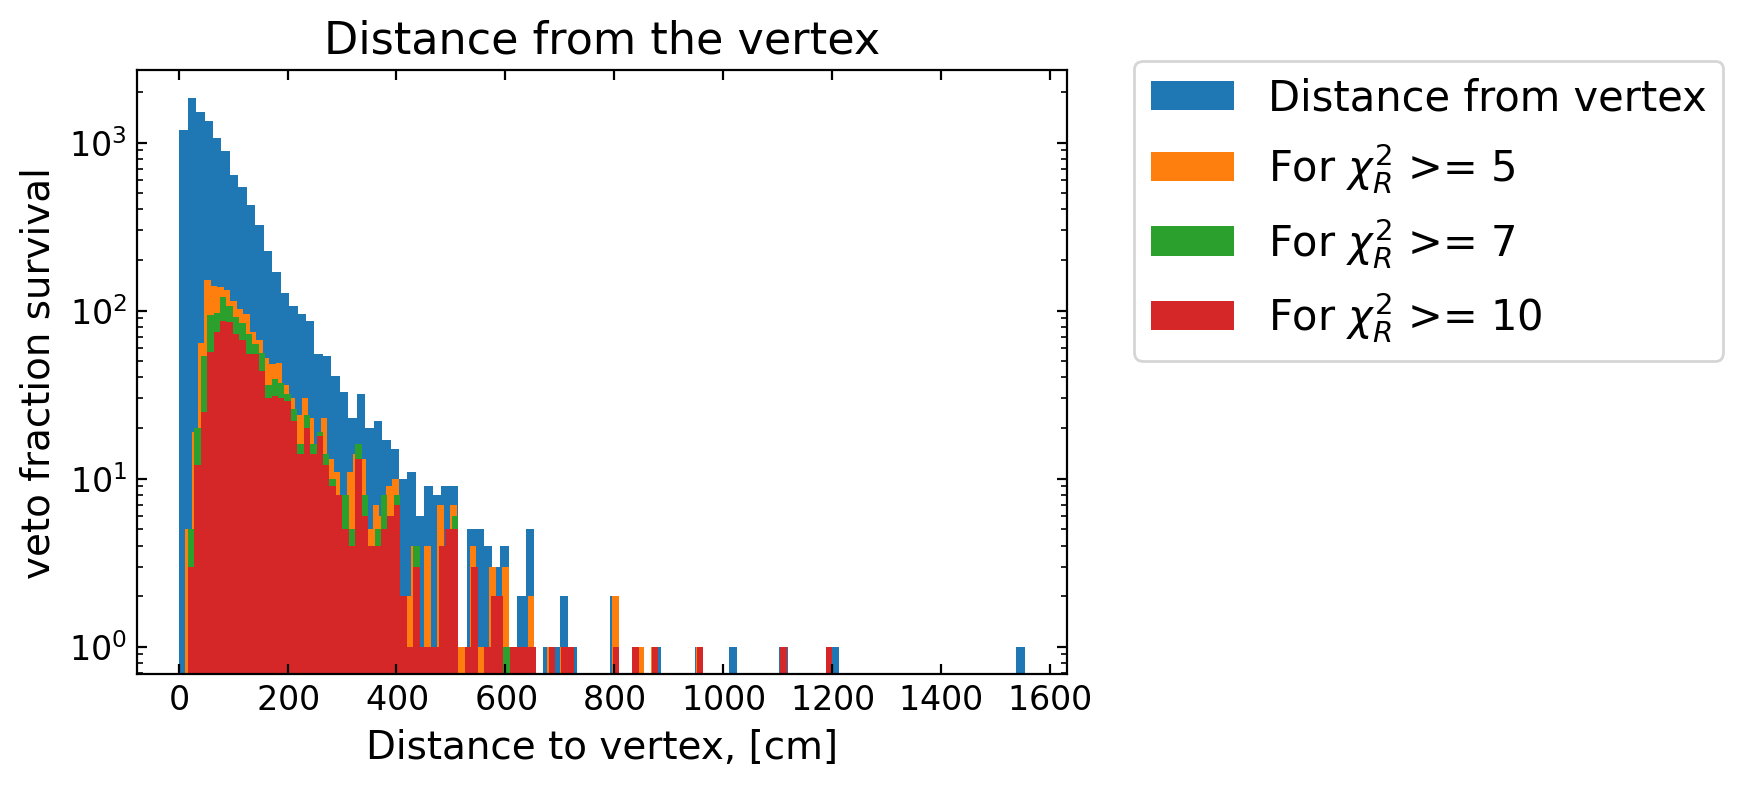

In [23]:
bincenters=[5,7,10]
plt.hist(veto_herm["Ip_chi2_dist"][:,0], label = "Distance from vertex");

plt.hist(veto_herm["Ip_chi2_dist"][:,0][veto_herm["Ip_chi2"]/2 >= 5], label = "For $\chi_{R}^{2}$ >= 5");
plt.hist(veto_herm["Ip_chi2_dist"][:,0][veto_herm["Ip_chi2"]/2 >= 7], label = "For $\chi_{R}^{2}$ >= 7");
plt.hist(veto_herm["Ip_chi2_dist"][:,0][veto_herm["Ip_chi2"]/2 >= 10], label= "For $\chi_{R}^{2}$ >= 10");
title("Distance from the vertex")
legend()
yscale("log")
ylabel("veto fraction survival")
xlabel("Distance to vertex, [cm]")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

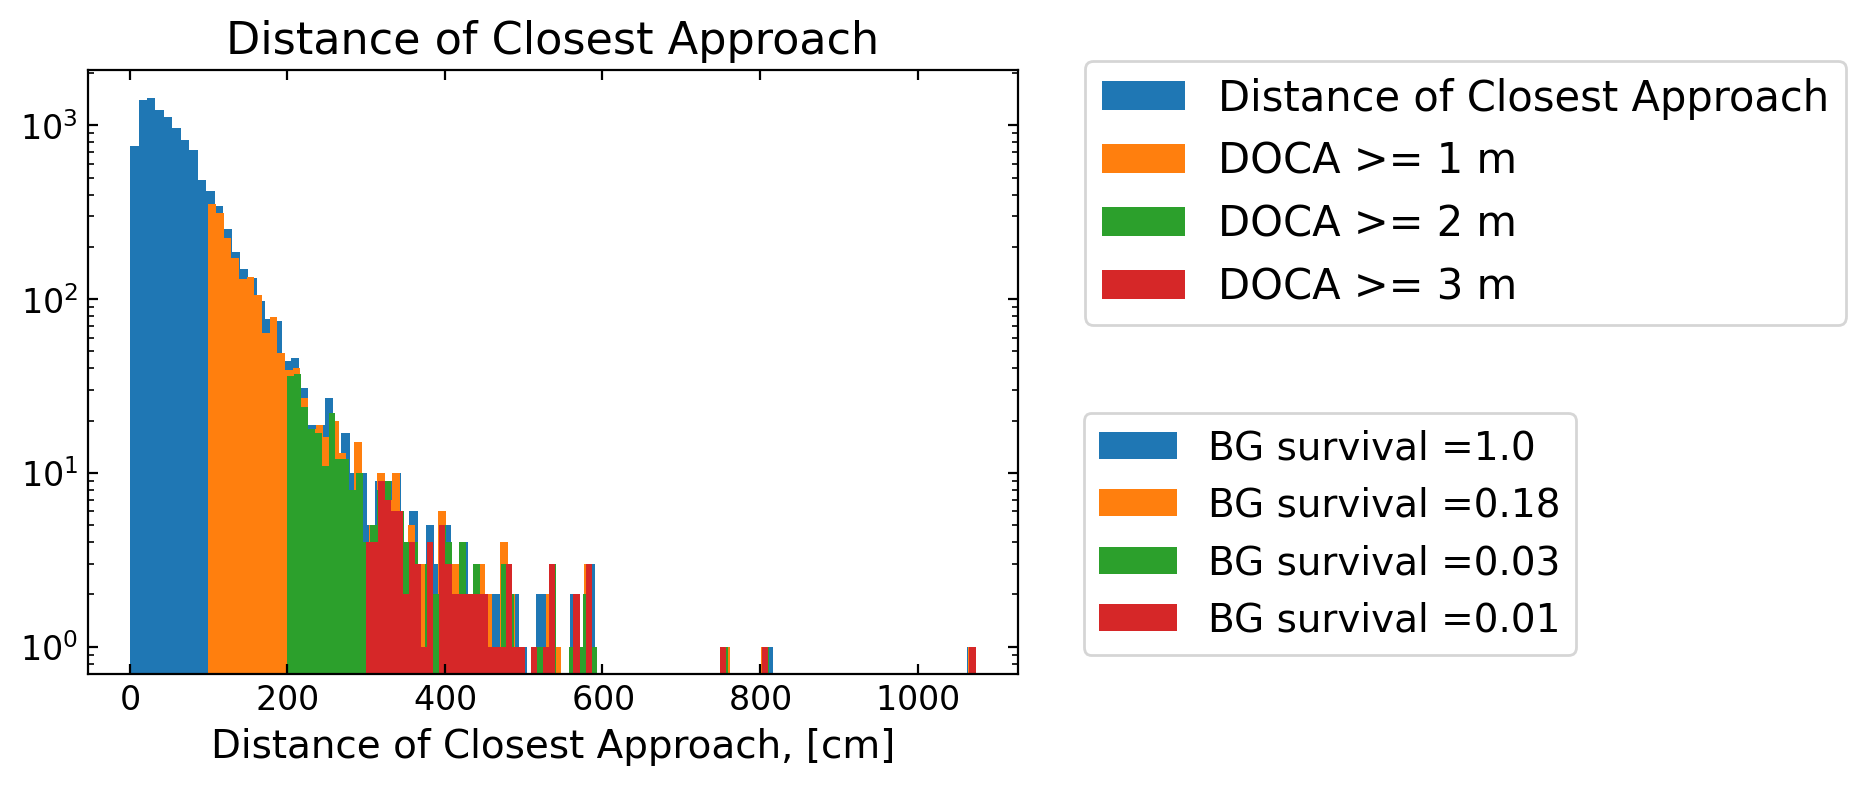

In [93]:
bincenters=[5,7,10]
nevents=len(veto_herm["Ip_chi2_dist"])
chi_doca1_cut =  veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1]>= 100]
chi_doca2_cut =  veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1]>= 200]
chi_doca3_cut = veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1]>= 300]
chi_doca4_cut = veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1]>= 400]

survive=np.round(np.array([1,len(chi_doca1_cut)/nevents,  len(chi_doca2_cut)/nevents, len(chi_doca3_cut)/nevents]),2)


plt.hist(veto_herm["Ip_chi2_dist"][:,1], label = "Distance of Closest Approach");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1] >= 100], label  = "DOCA >= 1 m");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1] >= 200], label  = "DOCA >= 2 m");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2_dist"][:,1] >= 300], label  = "DOCA >= 3 m");
title("Distance of Closest Approach")
legend()
yscale("log")
#ylabel("veto fraction survival")
xlabel("Distance of Closest Approach, [cm]")
reduced_chi2_sur=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })
lines = plt.gca().get_lines()
plt.gca().add_artist(reduced_chi2_sur)

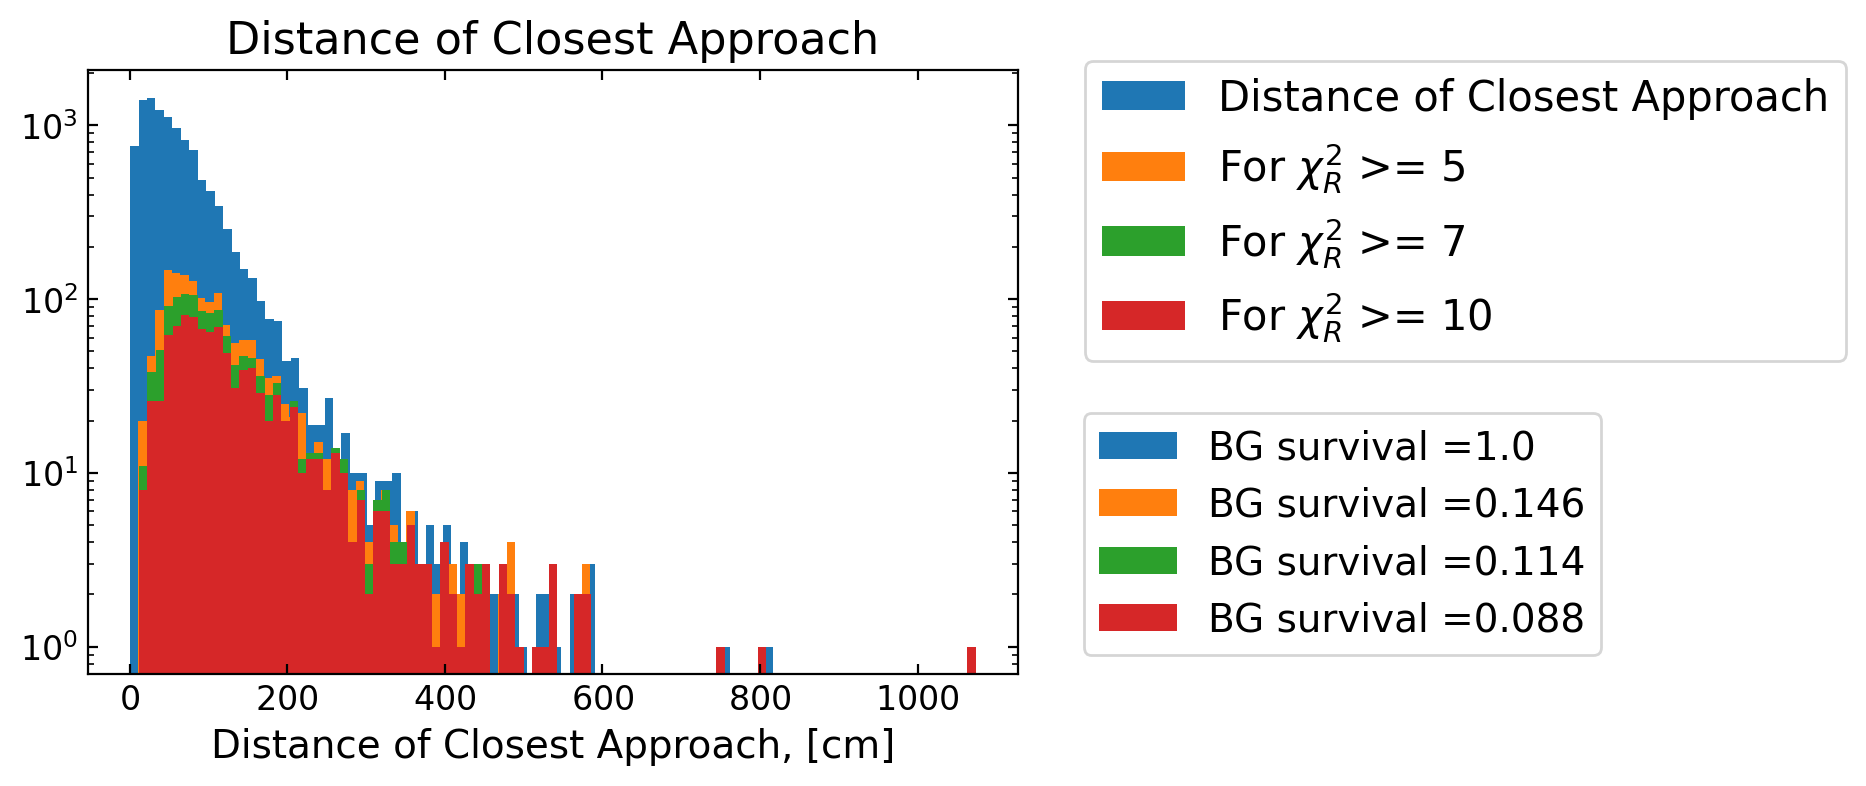

In [ ]:
bincenters=[5,7,10]
chi_doca1_cut =  veto_herm["Ip_chi2_dist"][veto_herm["Ip_chi2"]>= 10]
chi_doca2_cut =  veto_herm["Ip_chi2_dist"][veto_herm["Ip_chi2"]>= 14]
chi_doca3_cut = veto_herm["Ip_chi2_dist"][veto_herm["Ip_chi2"]>= 20]


survive=np.round(np.array([1,len(chi_doca1_cut)/nevents,  len(chi_doca2_cut)/nevents, len(chi_doca3_cut)/nevents]),3)




plt.hist(veto_herm["Ip_chi2_dist"][:,1], label = "Distance of Closest Approach");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2"]/2 >= 5], label = "For $\chi_{R}^{2}$ >= 5");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2"]/2 >= 7], label = "For $\chi_{R}^{2}$ >= 7");
plt.hist(veto_herm["Ip_chi2_dist"][:,1][veto_herm["Ip_chi2"]/2 >= 10], label= "For $\chi_{R}^{2}$ >= 10");
title("Distance of Closest Approach")
legend()
yscale("log")
#ylabel("veto fraction survival")
xlabel("Distance of Closest Approach, [cm]")
reduced_chi2_sur=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })
lines = plt.gca().get_lines()
plt.gca().add_artist(reduced_chi2_sur)

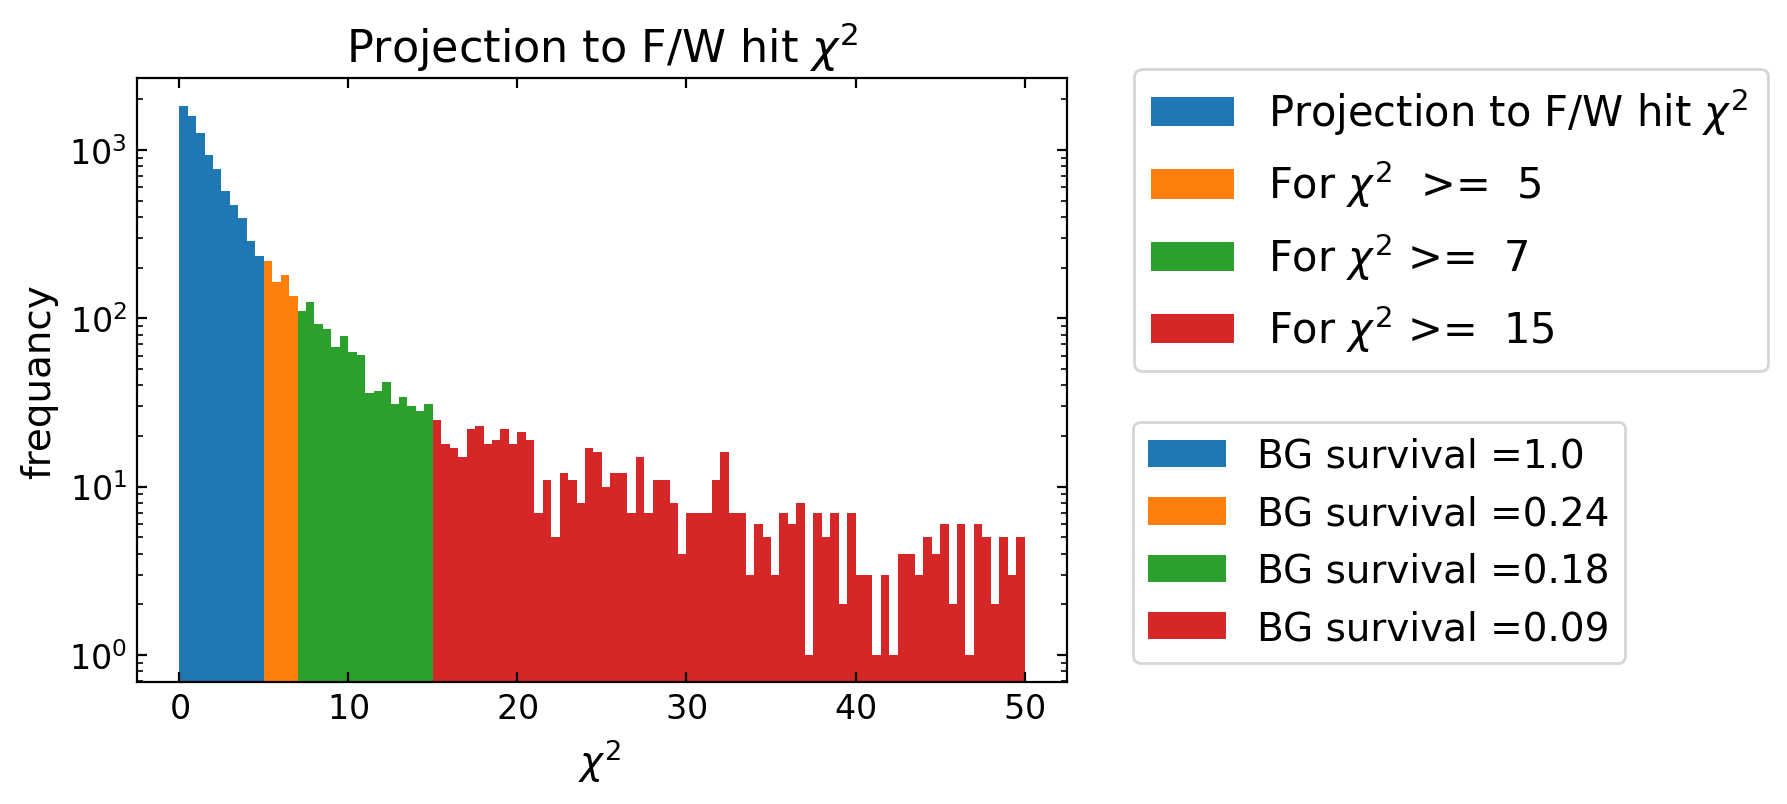

In [64]:
bincenters=[5,7,10]
nevents=len(veto_herm["fwhit_chi2"])
chi_5_cut = veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"]>= 5]
chi_7_cut = veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"]>= 7]
chi_15_cut = veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"]>= 15]
survive=np.round(np.array([1,len(chi_5_cut)/nevents,  len(chi_7_cut)/nevents,   len(chi_15_cut)/nevents]),2)
plt.hist((veto_herm["fwhit_chi2"]) , range= [0,50], label = "Projection to F/W hit $\chi^{2}$ ");
plt.hist(veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"]>= 5], range= [0,50] , label = f"For $\chi^{2}$  >=  5 ");
plt.hist(veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"] >= 7], range= [0,50] , label = f"For $\chi^{2}$ >=  7 ");
plt.hist(veto_herm["fwhit_chi2"][veto_herm["fwhit_chi2"] >= 15], range= [0,50] , label= f"For $\chi^{2}$ >=  15");

title("Projection to F/W hit $\chi^{2}$")
legend()
yscale("log")
ylabel("frequancy")
xlabel("$\chi^{2}$ ")

legend1=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })
lines = plt.gca().get_lines()
plt.gca().add_artist(legend1)

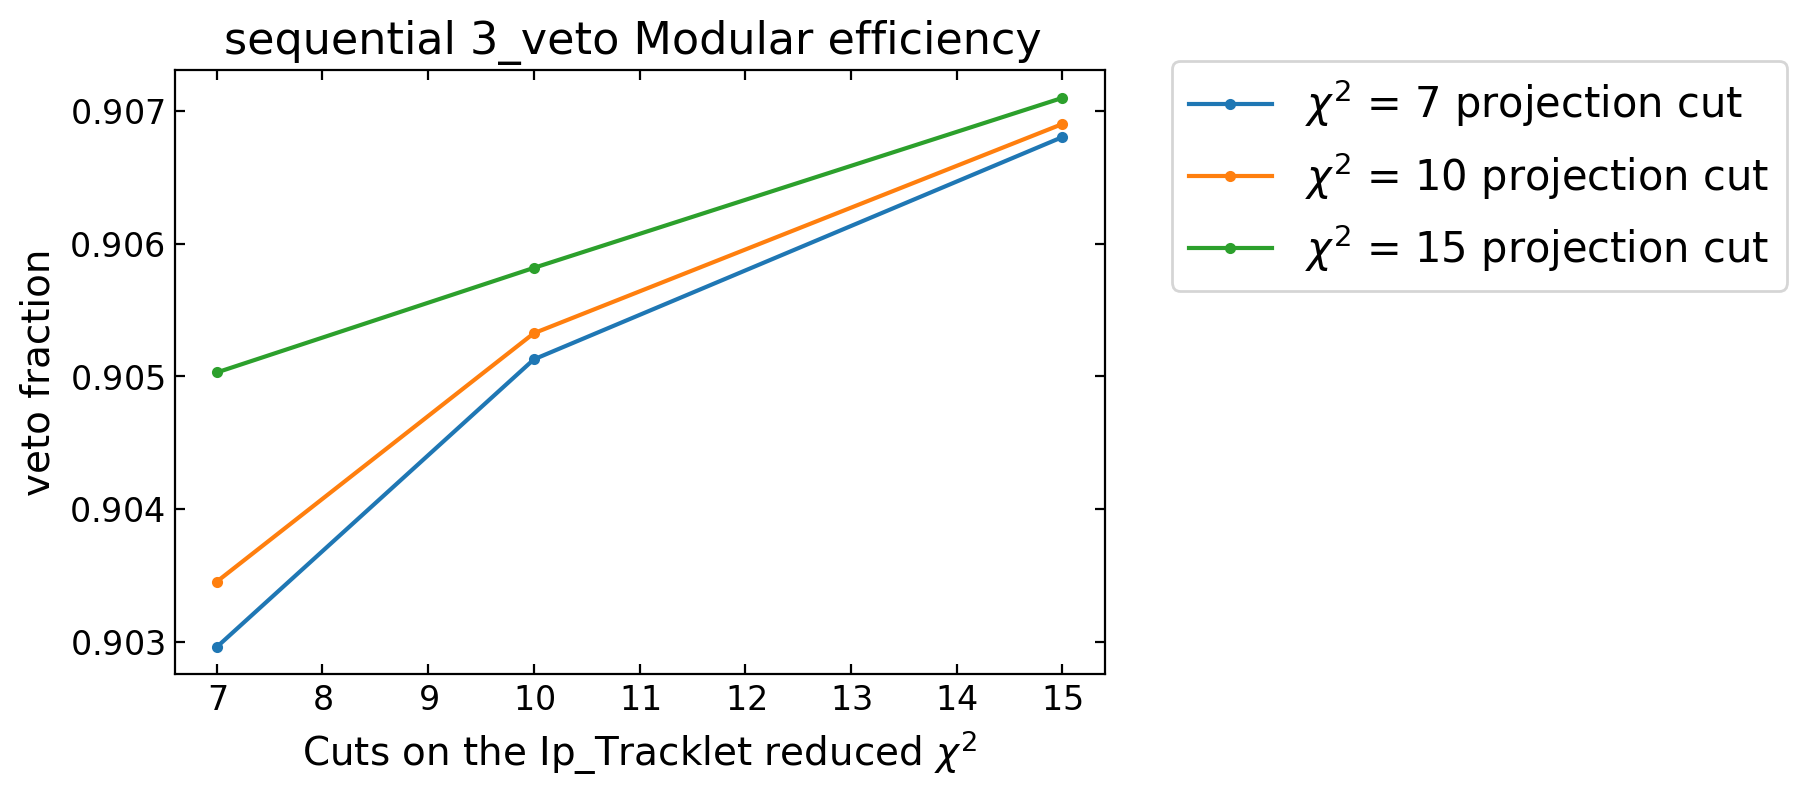

In [58]:
bincenters=[7,10,15]
proj_cut_7= [0.9029627426287925, 0.9051276707925399, 0.9068005698281627]
proj_cut_10=[0.9034547717569169, 0.9053244824437896, 0.9068989756537876]
proj_cut_15=[0.9050292649669149, 0.905816511571914, 0.9070957873050374]
plt.errorbar(bincenters,proj_cut_7,ls="-" ,fmt=".", capsize=4,label= "$\chi^2$ = 7 projection cut ");
plt.errorbar(bincenters,proj_cut_10,ls="-" ,fmt=".", capsize=4,label= "$\chi^2$ = 10 projection cut ");
plt.errorbar(bincenters,proj_cut_15,ls="-" ,fmt=".", capsize=4,label= "$\chi^2$ = 15 projection cut ");

title("sequential 3_veto Modular efficiency ")
legend()
ylabel("veto fraction")
xlabel("Cuts on the Ip_Tracklet reduced $\chi^2$")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

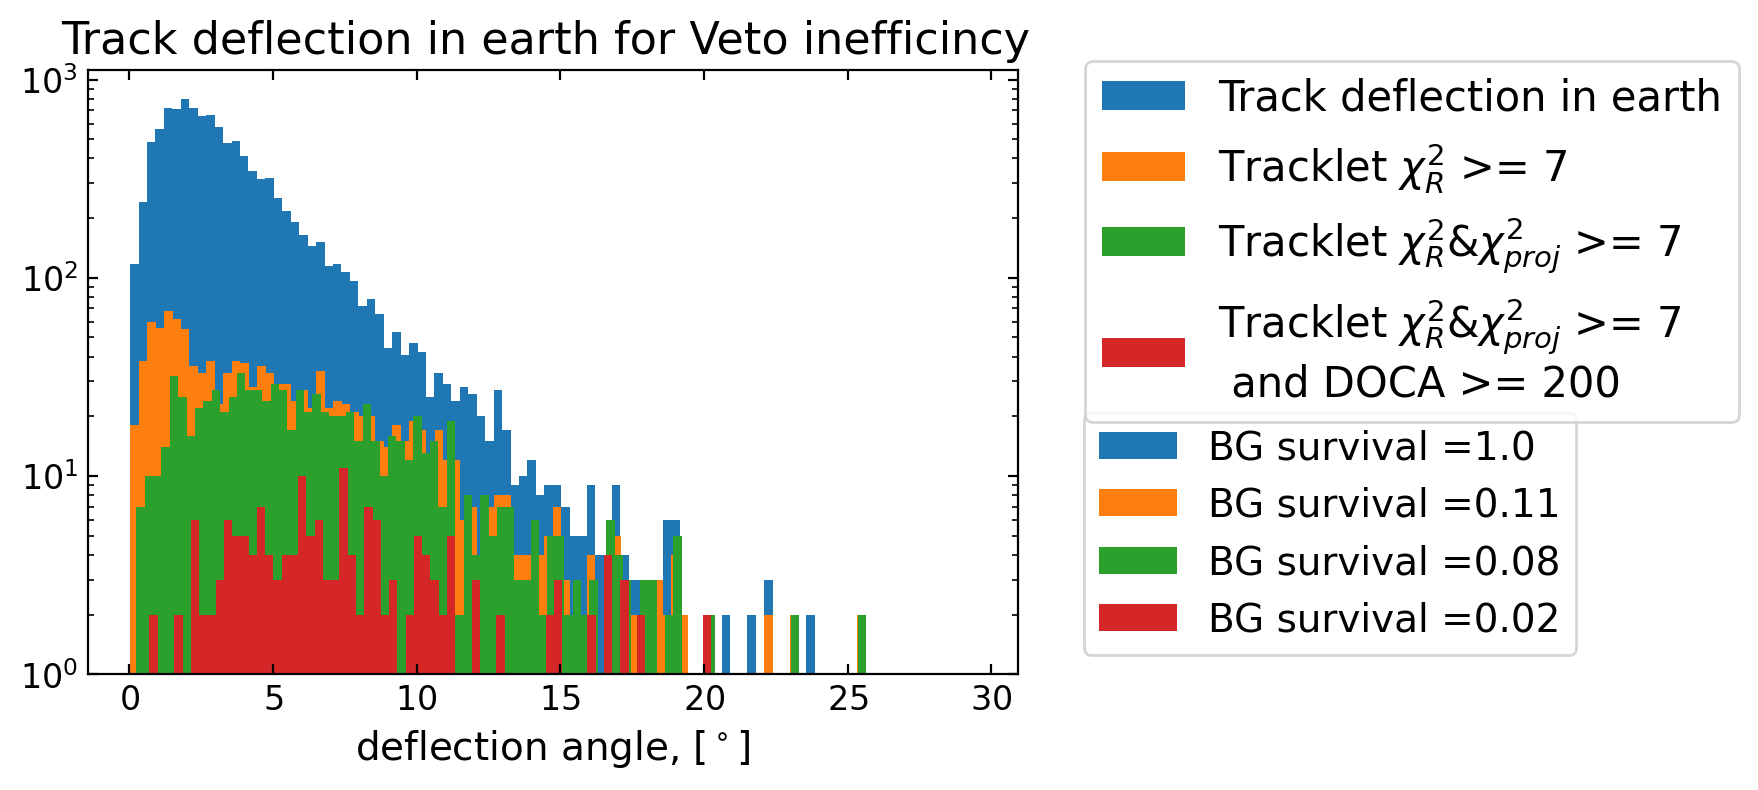

In [11]:
nevents=len(veto_herm["fwhit_chi2"])
chi_fw_cut =  veto_herm["deflection"][(veto_herm["Ip_chi2"] >= 14)]
chi_ip_cut =  veto_herm["deflection"][(veto_herm["Ip_chi2"] >= 14) & (veto_herm["fwhit_chi2"] >= 10) ]
chi_doca_cut = veto_herm["deflection"][(veto_herm["Ip_chi2"] >= 14) & (veto_herm["fwhit_chi2"] >= 10) & (veto_herm["Ip_chi2_dist"][:,1] >= 200)]
survive = np.round(np.array([1,len(chi_fw_cut)/nevents,len(chi_ip_cut)/nevents,len(chi_doca_cut)/nevents]),2)
proj="proj"
Tracklet="Tracklet"
plt.hist(veto_herm["deflection"]/np.pi*180, label = "Track deflection in earth");
plt.hist(veto_herm["deflection"][veto_herm["Ip_chi2"] >= 14]/np.pi*180, label =        "Tracklet $\chi_{R}^2$ >= 7"  );
plt.hist(veto_herm["deflection"][(veto_herm["Ip_chi2"] >= 14) & (veto_herm["fwhit_chi2"] >= 10)]/np.pi*180, label = "Tracklet $\chi_{R}^2 & \chi_{proj}^2 $ >= 7" );
plt.hist(veto_herm["deflection"][(veto_herm["Ip_chi2"] >= 14) & (veto_herm["fwhit_chi2"] >= 10) & (veto_herm["Ip_chi2_dist"][:,1] >= 200)]/np.pi*180,label= "Tracklet $\chi_{R}^2 & \chi_{proj}^2 $ >= 7 \n and DOCA >= 200 " );






title("Track deflection in earth for Veto inefficincy ")
yscale("log")
ylim(bottom=1 )
legend()
xlabel(r"deflection angle, [$^\circ$]")
legend1=plt.legend([f"BG survival ={survive[i]}" for i in [0,1,2,3]], bbox_to_anchor=(1.05,0), loc='lower left')
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

lines = plt.gca().get_lines()
plt.gca().add_artist(legend1)

In [7]:
survive

array([1.  , 0.11, 0.08, 0.02])

In [40]:
# vertex first # 
#bincenters=[5,7,10]
hprojection=[0.04387,0.038,0.0324]
hvertex=[0.9357,0.949, 0.9614]
hermetic_eff=[0.9796,0.987,0.9939] 
# vertex first Modular # 
#bincenters=[5,7,10]
projection=[0.037,0.032,0.0273]
vertex=[0.850,0.8642,0.8766]
Modular_eff=[0.887,0.897,0.904] 


In [9]:
dist=[]
passed=0
for eve in failed:
    d2g=Veto.d2gap(data,eve)
    if d2g[0] and d2g[1] <= 50:
        passed=passed+1 
    else:
        continue
(passed/52)*0.00785 + 0.9921

0.9961759615384616

## Modular

In [22]:

## Modular Effeciancy ##
veto_list=[5,7,10]
eff=[]
eff_ip=[]
eff_fwhit=[]
eff_dist=[]
dist=[]
eff_d2gap=[]
n_events=len(veto_mod["fwhit_chi2"])
for veto in veto_list:
    vetoed_dist=0
    vetoed_ip = 0
    vetoed_fwhit=0
    vetoed_d2g= 0
    for ind in range(len(veto_mod["fwhit_chi2"])):
        
        dist_list=[]
        if  veto_mod["fail_mask"][ind] == False and veto_mod["Ip_chi2_dist"][ind][1] <= 200:
            vetoed_dist = vetoed_dist + 1
        
        elif veto_mod["Ip_chi2"][ind]/ 2 <= veto and veto_mod["fail_mask"][ind] == False:
            vetoed_ip  = vetoed_ip  +1
            
        elif veto_mod["fwhit_chi2"][ind] <= 10 and  veto_mod["fail_mask"][ind] == False:
            vetoed_fwhit = vetoed_fwhit + 1
        

        elif veto_mod["fail_mask"][ind] == False  and  veto_mod["d2gap"][ind][0] >=0 and veto_mod["d2gap"][ind][0] <=50 and  veto_mod["d2gap"][ind][1] <=700: 
            vetoed_d2g = vetoed_d2g + 1
            if veto == 7:
                dist.append(veto_mod["d2gap"][ind][0])
    vetoed=vetoed_fwhit+ vetoed_ip+ vetoed_dist + vetoed_d2g 
    eff.append(((vetoed/n_events)))
    eff_ip.append(vetoed_ip/n_events)
    eff_fwhit.append(vetoed_fwhit/n_events)
    eff_dist.append(vetoed_dist/n_events)
    eff_d2gap.append((vetoed_d2g/n_events))

eff

[0.9054839295442164, 0.907027419647721, 0.9085709097512257]

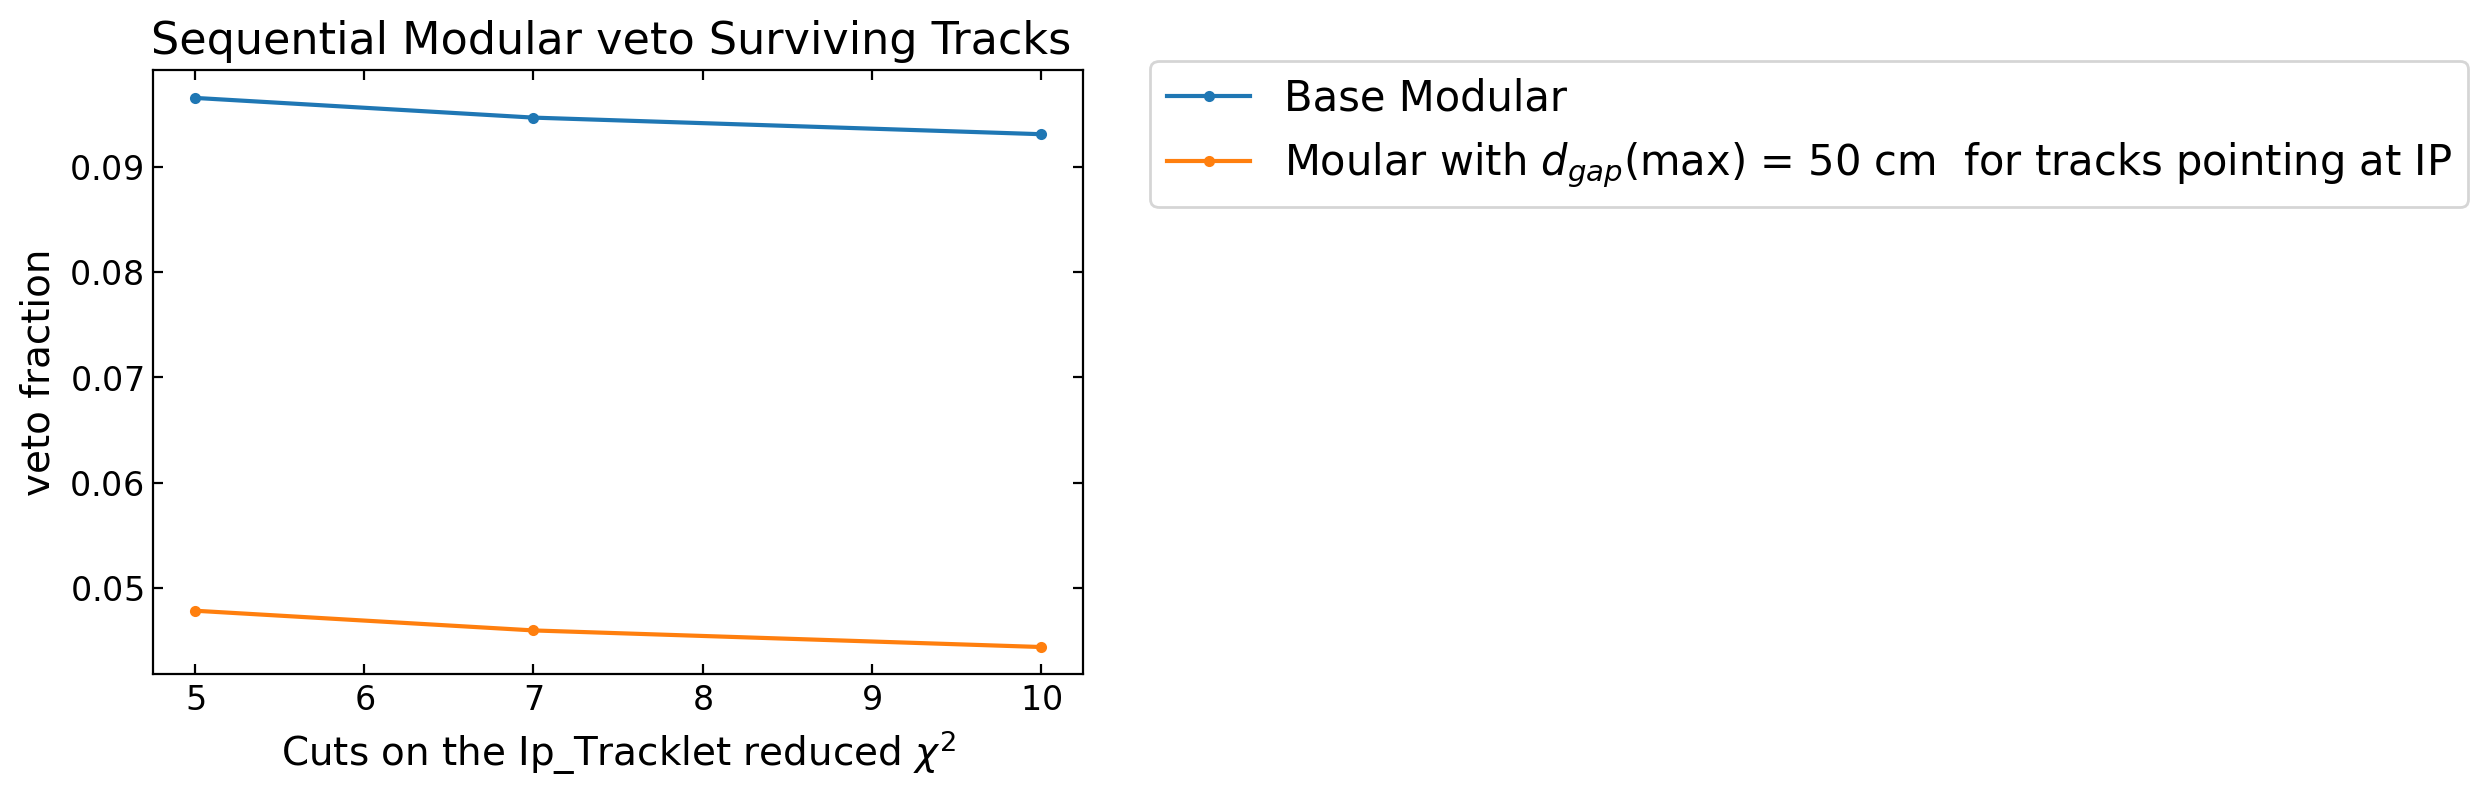

In [73]:
bincenters = [5,7,10 ] 
eff__ip_proj_d2g=1 - (np.array([0.9038483950594164, 0.9057181057462891, 0.9072925989562871]) + 0.0483)
#eff_d2g= [0.9095559329456593, 0.9109336145044076, 0.9122128902375309]
eff_modular = 1 - (np.array([0.9034547717569169, 0.9053244824437896, 0.9068989756537876]))
plt.errorbar(bincenters,eff_modular ,ls="-" ,fmt=".", capsize=4,label= "Base Modular ");
plt.errorbar(bincenters,eff_d2g,ls="-" ,fmt=".", capsize=4,label= "Moular with d2gap <= 50 cm");
plt.errorbar(bincenters,eff__ip_proj_d2g,ls="-" ,fmt=".", capsize=4,label= "Maximal modified Moudlar (dmax = 50 cm)");

title("Sequential Modular veto Surviving Tracks ")
legend()
ylabel("veto fraction")
xlabel("Cuts on the Ip_Tracklet reduced $\chi^2$")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

In [74]:
d2g_total_eff = eff_d2gap[1]
bins=[5*x for x in range(11)]
eff_gain=[]
for binpoint in bins:
    vetos=0
    for ds in dist:
        if ds <= binpoint:
            vetos=vetos+1
    eff_gain.append(( vetos/len(dist) )*(d2g_total_eff))


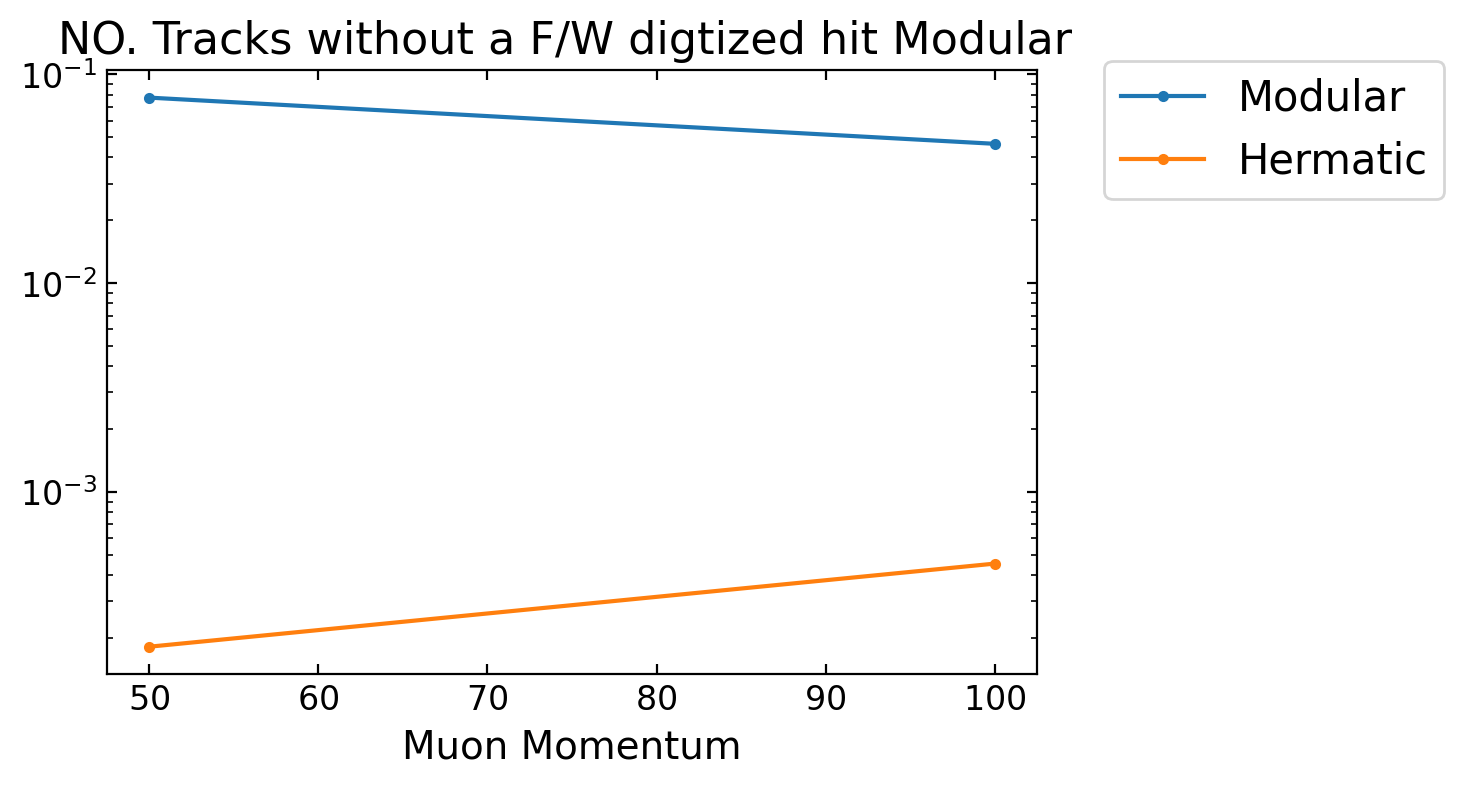

In [76]:
bincenters = [50,100] 
eff__ip_proj_d2g=1 - (np.array([0.9038483950594164, 0.9057181057462891, 0.9072925989562871]) + 0.0483)
#eff_d2g= [0.9095559329456593, 0.9109336145044076, 0.9122128902375309]
eff_modular = 1 - (np.array([0.9034547717569169, 0.9053244824437896, 0.9068989756537876]))
plt.errorbar(bincenters,[852/11014,512/11014],ls="-" ,fmt=".", capsize=4,label= "Modular");
plt.errorbar(bincenters,[2/11014,5/11014],ls="-" ,fmt=".", capsize=4,label= "Hermatic");


title("NO. Tracks without a F/W digtized hit Modular ")
legend()
#ylabel("veto fraction")
yscale("log")
xlabel("Muon Momentum")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 15 })

In [96]:
[852/11014,362/11014]

0.07735609224623206

In [69]:
[2/11014,5/11014]

0.00018158707100054475

In [49]:
survive = np.array([0.0773,
 0.0314825117370892,
 0.031119600938967137,
 0.03084741784037559,
 0.030575234741784037,
 0.03048450704225352,
 0.030303051643192483,
 0.030212323943661974,
 0.03012159624413146,
 0.030030868544600936,
 0.02994014084507042,
 0.02994014084507042,
 0.02994014084507042,
 0.02994014084507042,
 0.02994014084507042,
 0.029849413145539905,
 0.02975868544600939,
 0.029667957746478874,
 0.029667957746478874,
 0.029667957746478874,
 0.02957723004694835,
 0.02957723004694835,
 0.02957723004694835,
 0.029486502347417842,
 0.029486502347417842,
 0.029486502347417842,
 0.029486502347417842,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.029305046948356804,
 0.02921431924882629,
 0.02921431924882629,
 0.02921431924882629,
 0.02921431924882629,
 0.02921431924882629,
 0.02921431924882629,
 0.02921431924882629,
 0.029123591549295773,
 0.029123591549295773,
 0.029123591549295773,
 0.029123591549295773,
 0.029123591549295773,
 0.029123591549295773,
 0.029032863849765257])

survive_4 = np.array([0.0773,
 0.023135563380281686,
 0.0226819248826291,
 0.02231901408450703,
 0.022046830985915485,
 0.02195610328638497,
 0.02177464788732393,
 0.02150246478873239,
 0.021321009389671353,
 0.021230281690140837,
 0.02095809859154929,
 0.02095809859154929,
 0.020867370892018768,
 0.020867370892018768,
 0.020867370892018768,
 0.02077664319248826,
 0.020685915492957736,
 0.02059518779342722,
 0.02059518779342722,
 0.02059518779342722,
 0.020504460093896705,
 0.020504460093896705,
 0.02041373239436619,
 0.020323004694835667,
 0.020323004694835667,
 0.020323004694835667,
 0.020323004694835667,
 0.020141549295774636,
 0.020141549295774636,
 0.020141549295774636,
 0.020141549295774636,
 0.020141549295774636,
 0.020141549295774636,
 0.020050821596244127,
 0.020050821596244127,
 0.020050821596244127,
 0.020050821596244127,
 0.019960093896713604,
 0.019960093896713604,
 0.019960093896713604,
 0.019960093896713604,
 0.019960093896713604,
 0.019960093896713604,
 0.019960093896713604,
 0.01986936619718309,
 0.01986936619718309,
 0.019778638497652573,
 0.019778638497652573,
 0.019778638497652573,
 0.019778638497652573,
 0.019687910798122057])

survive_5=np.array([0.0773,
 0.020050821596244127,
 0.019597183098591542,
 0.01923427230046948,
 0.018962089201877926,
 0.01887136150234741,
 0.01868990610328638,
 0.018326995305164316,
 0.018145539906103278,
 0.017964084507042247,
 0.0176919014084507,
 0.0176919014084507,
 0.017601173708920177,
 0.017601173708920177,
 0.017601173708920177,
 0.017419718309859146,
 0.01732899061032863,
 0.017238262910798115,
 0.017238262910798115,
 0.017238262910798115,
 0.0171475352112676,
 0.0171475352112676,
 0.016875352112676052,
 0.01678462441314553,
 0.01678462441314553,
 0.01678462441314553,
 0.01678462441314553,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016421713615023467,
 0.016421713615023467,
 0.016421713615023467,
 0.016421713615023467,
 0.016240258215962436,
 0.016240258215962436,
 0.016240258215962436,
 0.016149530516431913,
 0.016149530516431913,
 0.016149530516431913,
 0.016058802816901398,
 0.01596807511737089,
 0.01596807511737089,
 0.015877347417840366,
 0.015877347417840366,
 0.015877347417840366,
 0.015877347417840366,
 0.01578661971830985])


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


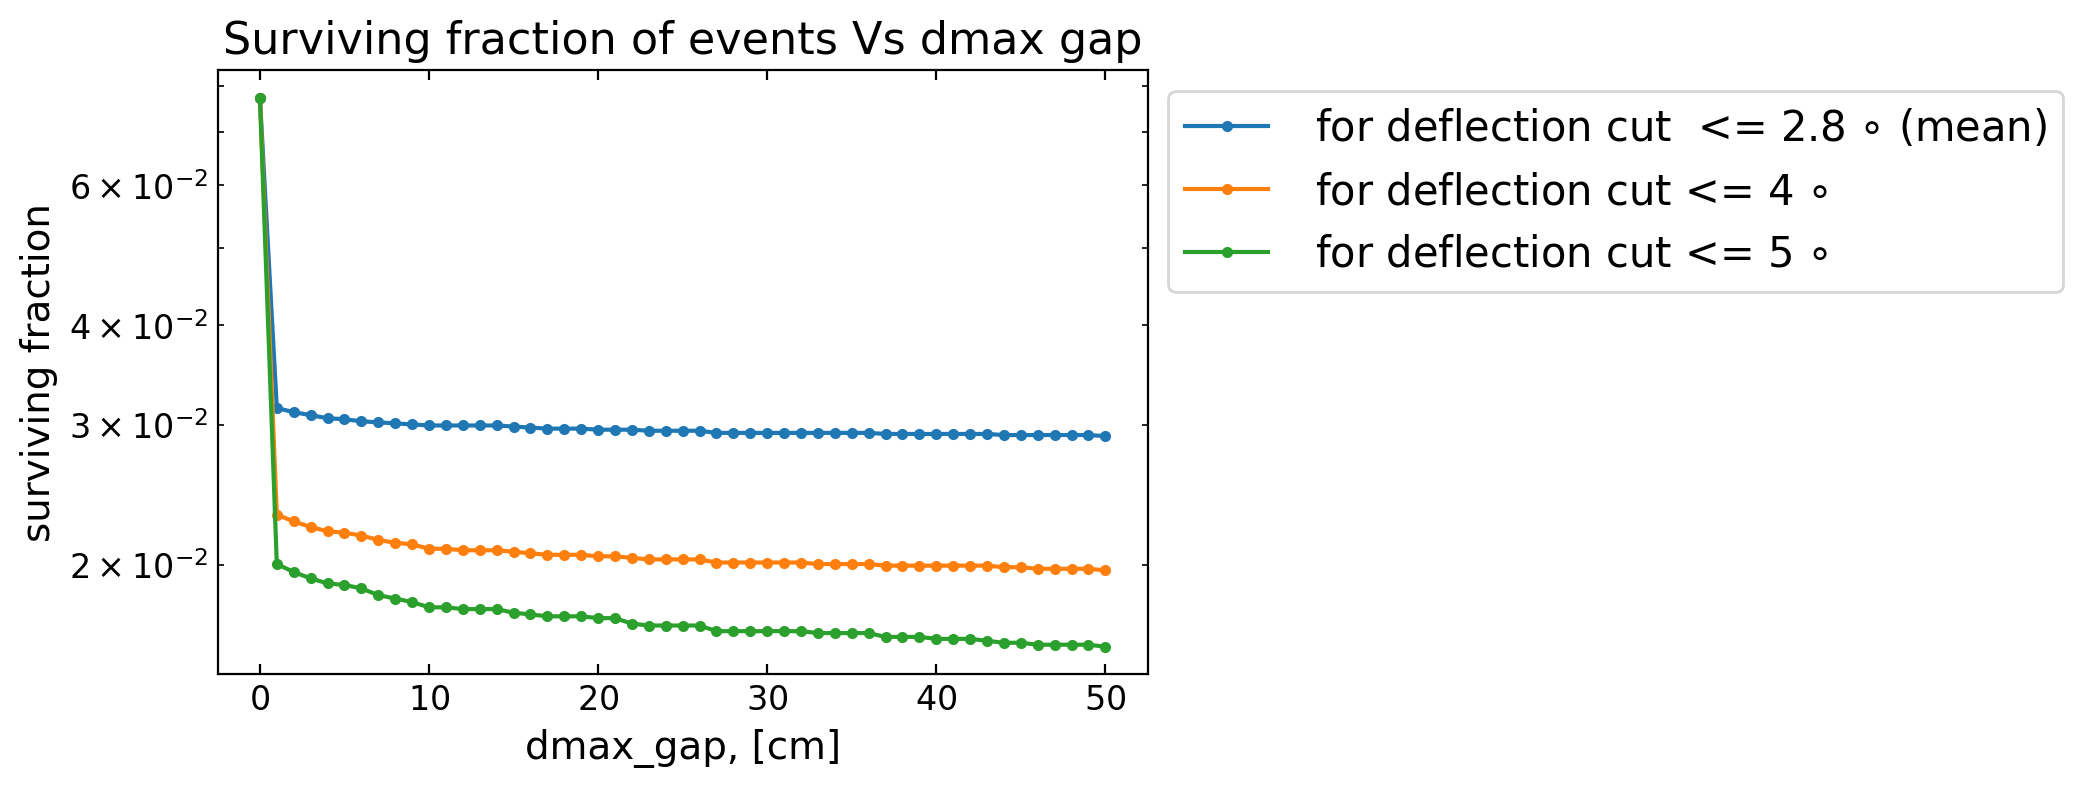

In [52]:
bincenters=[x for x in range(51)]
plt.errorbar(bincenters,survive,  ls="-" ,fmt=".", capsize=4, label = " for deflection cut  <= 2.8 $\circ$ (mean)"); 
plt.errorbar(bincenters,survive_4,ls="-" ,fmt=".", capsize=4,  label = " for deflection cut <= 4 $\circ$" ) 
plt.errorbar(bincenters,survive_5,ls="-" ,fmt=".", capsize=4,  label = " for deflection cut <= 5 $\circ$" )
title("Surviving fraction of events Vs dmax gap")
legend()
ylabel("surviving fraction")
yscale("log")
xlabel("dmax_gap, [cm]")
plt.legend( bbox_to_anchor=(1.0, 1.0), loc="upper left", prop = { "size": 15 })

Text(0.5, 0, 'deflection angle, [$\\circ$]')

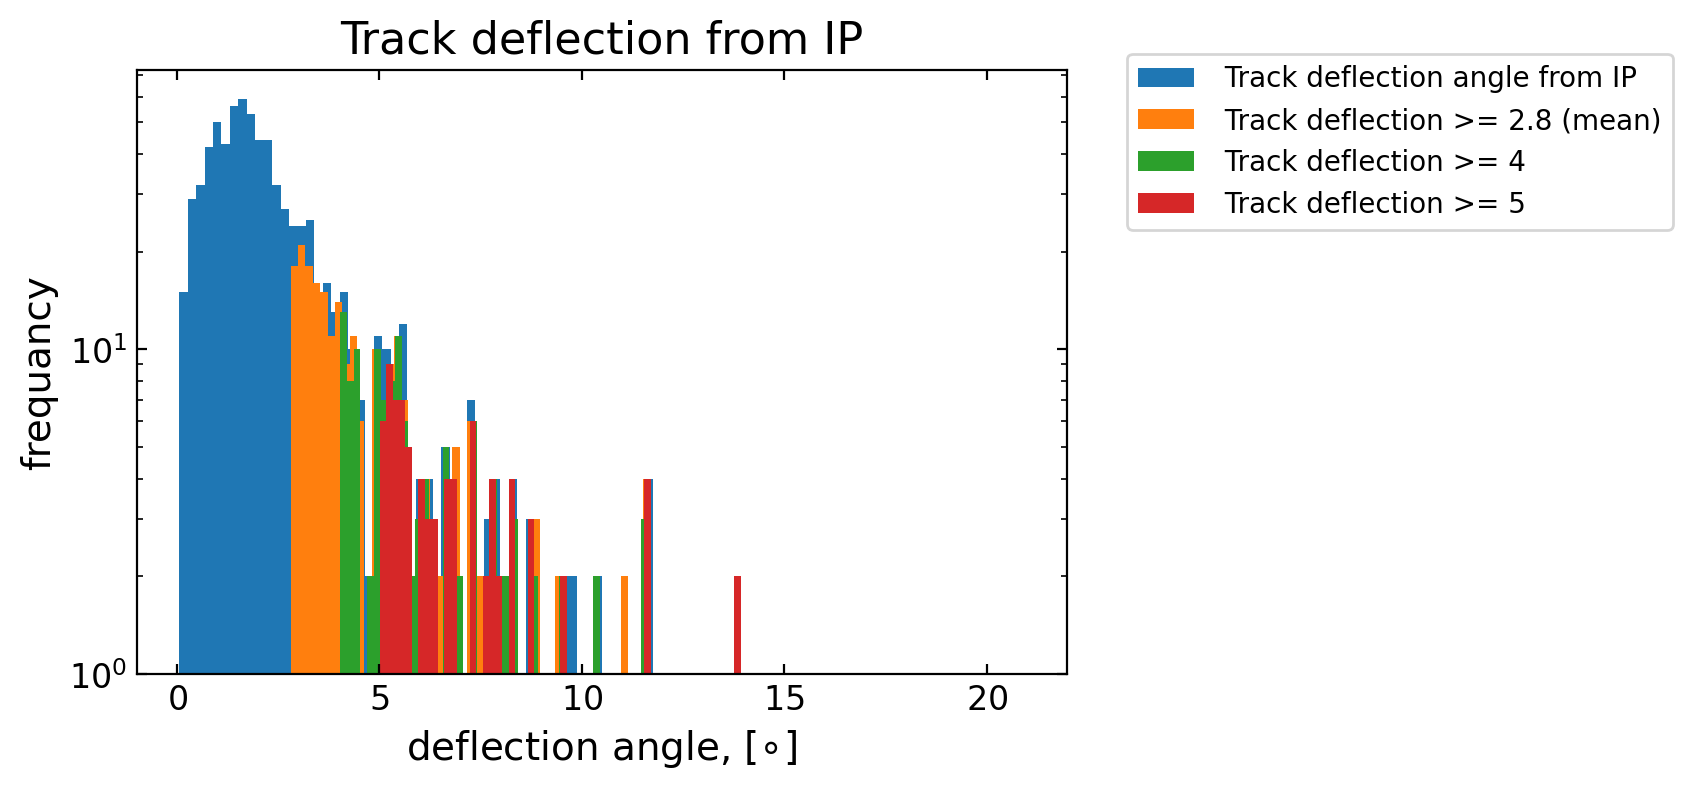

In [41]:
plt.hist(d2g_mod["deflection"], label = " Track deflection angle from IP "); 
plt.hist(d2g_mod["deflection"][d2g_mod["deflection"] >= 2.8], label = " Track deflection >= 2.8 (mean)" ) 
plt.hist(d2g_mod["deflection"][d2g_mod["deflection"] >= 4], label = " Track deflection >= 4 " ) 
plt.hist(d2g_mod["deflection"][d2g_mod["deflection"] >= 5], label = " Track deflection >= 5 " ) 
yscale("log")
ylim(bottom=1 )
plt.legend()
plt.title("Track deflection from IP")
plt.legend( bbox_to_anchor=(1.05, 1.05), loc='upper left', prop = { "size": 10 })
ylabel("frequancy")
xlabel("deflection angle, [$\circ$]")

In [45]:
veto=0
dist=[]
for ind in range(len(d2g_mod["d2gap"])):
    d2gap=d2g_mod["d2gap"][ind]
    deflect = d2g_mod["deflection"][ind]
    if d2gap <= 50 and deflect <= 5 and d2gap >-999 :
        dist.append(d2gap)
        veto=veto+1
eff_d2g_veto=veto/852
eff_d2g_veto

0.795774647887324

In [46]:
bins=[x for x in range(51)]
eff_gain=[]
for binpoint in bins:
    vetos=0
    for ds in dist:
        if ds <= binpoint:
            vetos=vetos+1
    eff_gain.append(0.0773-( vetos/len(dist) )*(eff_d2g_veto*0.0773))
eff_gain

[0.020141549295774643,
 0.020050821596244127,
 0.019597183098591542,
 0.01923427230046948,
 0.018962089201877926,
 0.01887136150234741,
 0.01868990610328638,
 0.018326995305164316,
 0.018145539906103278,
 0.017964084507042247,
 0.0176919014084507,
 0.0176919014084507,
 0.017601173708920177,
 0.017601173708920177,
 0.017601173708920177,
 0.017419718309859146,
 0.01732899061032863,
 0.017238262910798115,
 0.017238262910798115,
 0.017238262910798115,
 0.0171475352112676,
 0.0171475352112676,
 0.016875352112676052,
 0.01678462441314553,
 0.01678462441314553,
 0.01678462441314553,
 0.01678462441314553,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016512441314553983,
 0.016421713615023467,
 0.016421713615023467,
 0.016421713615023467,
 0.016421713615023467,
 0.016240258215962436,
 0.016240258215962436,
 0.016240258215962436,
 0.016149530516431913,
 0.016149530516431913,
 0.016149530516431913,
 0.016058802816901398,
 0.0